In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import hashlib

sns.set()

RFA before - 0 типа неизвестно?
Cyberknife - соотношение 99/2 - это скорее не прошли/прошли лучевую, чем наоборот?

In [2]:
from utils.preprocessing import read_excel_sheets
table_names, tables = read_excel_sheets('./data/data.xls')
categorical_raw = tables[table_names[-1]]
quant_raw = tables[table_names[1]]

In [3]:
be_features = [
    'PTV be', 'PTI be', 'MNObe', 'APTV be', 'ALT be', 'AST be',
    'bil be', 'prot be', 'gluc be', 'creat be', 'L be', 'er be',
    'Hb be', 'tr be'
]

features = [
    'localisat group', # dummy localisat group=1,2,3
    'T', 
    'Number mts', # + new binary feature Number mts>9
    'Subcaps/Intrapar', # dummy Subcaps/Intrapar=1,2
    'N', 'how many positive', 'mts max size, mm', 'summ size of all mts', 
    'M', 'vessel invasion', 'caps invasion', 
    'CEA before', # to handle missing values - 40/101
    'Month till mts',
    'Lobe(l-1,r-2)', # dummy lobe-r, lobe-l
    'Grade prim', # 5->0 for 12 unknown
    'Age at operation', 
    'Sex', # 1->0 as female, 2->1 as male
    # 'Angiography'
    'CT-AG/AG', # dummy in CAT-AG, AG
    'PV-embol', 'ХЭПА', 
    'RFA before', # in binary RFA before (1=yes, 0=no), 3,4->1
    'Chemo regim before oper', # to binary: 
    # Folfox, Folfiri, Capec, Ftorafur, Meyo, Folfoxiri, DeGram, 5FU
    'Target ther', # to binary
    # 'Cyberknife', # 1==1, 2->0
    'Imag method', # to binary: CT, AG, US, MRI, PET-CT
    'Hepatic pathology', # to binary
    'second cancer', # to binary: 0->0, not0->1.
    # 'aft\\befor\\sinch', 
    'Diabetis', # 0==0, 2->1
    'hepar operat', # 1->0, not1->1.
    'Genetic', # to binary
    'Рост', 
    # 'Вес',
    'S', 'BMI group'
]

target = 'Outcome' # 1->0 (good), 2->1 (bad), 3->drop.

# Response ChTh, Chemo lines

convert_to_float = [
    'Number mts', 'vessel invasion', 'caps invasion', 
    'PV-embol', 'ХЭПА', 'S', 'BMI group'
]

low_or_skewed = [
            'ALT be', 'AST be', 
            'gluc be', 'creat be',
            'bill be', 
            'Month till mts', 'Number mts',
            'CEA before', 'summ size of all mts',
            'how many positive',
            'PTV be', 'PTI be', 'MNObe', 
            'APTV be', 'prot be', 'L be',
            'er be', 'Hb be', 'tr be',
            'Age at operation', 'S', 'Рост',
            'mts max size, mm']

In [4]:
df = tables[table_names[0]][:115].copy()
df['Surname/Name'] = df['Surname/Name'].apply(lambda x: hashlib.sha256(x.encode()).hexdigest())
df.head()

,Surname/Name,Date of birth,Num amb,Localisation Prim Tum,localisat group,Med Rec,Age at operation,Age group,date of operat,Angiography,...,AST be,bil be,prot be,gluc be,creat be,L be,er be,Hb be,tr be,ФВЛЖ
0,16cd53d75d67b00a89089bb65ce9c8e91dc04a50f4184b...,1947-10-26 00:00:00,616723,С18.7,2,3755-17,69.0,NaN,2017-03-14 00:00:00,0,...,30.0,9.8,66.0,4.50,54.0,6.20,4.20,124.0,283.0,65.0
1,ed0762773c975a396e83206f7452803681bfebde747e76...,1965-01-01 00:00:00,588225,С20,3,5282-17,52.0,NaN,2017-04-05 00:00:00,0,...,36.0,12.7,81.0,5.07,69.7,4.91,4.64,145.0,381.0,64.0
2,8094e625d1cb1e12bbeda62ca8010e829ef0be389992e8...,1940-01-07 00:00:00,218078,С20.1,3,14819-13,73.0,NaN,2013-10-09 00:00:00,ангиогр 22.05.14,...,60.0,17.0,70.0,6.00,70.0,6.88,4.17,113.0,233.0,66.0
3,1871490d5f50cd1adaf5e269be2fb19fead053f1fa19cf...,1951-06-15 00:00:00,211043,С18.2,1,15740-13,62.0,NaN,2013-10-21 00:00:00,CT-AG,...,27.0,6.4,71.0,4.37,61.2,5.35,3.75,112.0,183.0,53.0
4,712619e3d6ad90b4a9e467d89fd9a0f1360dec6e650be5...,1935-12-15 00:00:00,229216,С20.3,3,16884-13,77.0,NaN,2013-10-28 00:00:00,ХЭПА(Doxo),...,13.0,14.3,75.0,NaN,70.8,6.47,4.45,134.0,236.0,58.0


In [5]:
# drop patients whose outcome we do not know
cols = features + be_features + [target]

df = df[df['Outcome']!=3][cols]
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 47 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   localisat group          101 non-null    object 
 1   T                        101 non-null    float64
 2   Number mts               101 non-null    object 
 3   Subcaps/Intrapar         101 non-null    object 
 4   N                        101 non-null    float64
 5   how many positive        101 non-null    float64
 6   mts max size, mm         101 non-null    float64
 7   summ size of all mts     101 non-null    float64
 8   M                        101 non-null    float64
 9   vessel invasion          101 non-null    object 
 10  caps invasion            101 non-null    object 
 11  CEA before               61 non-null     float64
 12  Month till mts           101 non-null    float64
 13  Lobe(l-1,r-2)            101 non-null    object 
 14  Grade prim               1

# preprocessing

In [6]:
# target
def binarize_target(col : pd.Series):
    return col.map({1: 0, 2: 1})

In [7]:
def make_numerical(df: pd.DataFrame, convert_to_float: list[str] = ['']):
    df[convert_to_float] = df[convert_to_float].astype(float)
    return df

In [8]:
def change_categories(df: pd.DataFrame):
    # 'Grade prim', # 5->0 for 12 unknown
    df['Grade prim'] = df['Grade prim'].map({1:1, 2:2, 3:3, 5:0})
    
    #'Sex', # 1->0 as female, 2->1 as male
    df['Sex'] = df['Sex'].map({1:0, 2:1})
    
    # 'RFA before', # in binary RFA before (1=yes, 0=no), 3,4->1
    df['RFA before'] = df['RFA before'].map({1:1, 3:1, 4:1, 2:0, 0:0})

    # 'second cancer', # to binary: 0->0, not0->1.
    df['second cancer'] = df['second cancer'].map({0:0}).fillna(1)
    
    # 'Diabetis', # 0==0, 2->1
    df['Diabetis'] = df['Diabetis'].map({0:0, 2:1})
    
    # 'hepar operat', # 1->0, not1->1.
    df['hepar operat'] = df['hepar operat'].map({1:0, 2:1, 3:1})

    return df

In [9]:
def dummy(df: pd.DataFrame):
    
    # 'localisat group'
    df['local=1'] = df['localisat group'].map({1: 1}).fillna(0)
    df['local=2'] = df['localisat group'].map({2: 1}).fillna(0)
    df['local=3'] = df['localisat group'].map({3: 1}).fillna(0)
    df.drop(columns=['localisat group'], inplace=True)

    # 'Number mts', # + new binary feature Number mts>9
    df['Number mts>9'] = (df['Number mts']==9).astype(int)

    # 'Subcaps/Intrapar', # dummy Subcaps/Intrapar=1,2
    df['Subcaps'] = ((df['Subcaps/Intrapar']==3)|(df['Subcaps/Intrapar']==1)).astype(int)
    df['Intrapar'] = ((df['Subcaps/Intrapar']==3)|(df['Subcaps/Intrapar']==2)).astype(int)
    df.drop(columns=['Subcaps/Intrapar'], inplace=True)

    # 'Lobe(l-1,r-2)', # dummy lobe-r, lobe-l
    df['lobe=l'] = ((df['Lobe(l-1,r-2)']==3)|(df['Lobe(l-1,r-2)']==1)).astype(int)
    df['lobe=r'] = ((df['Lobe(l-1,r-2)']==3)|(df['Lobe(l-1,r-2)']==2)).astype(int)
    df.drop(columns=['Lobe(l-1,r-2)'], inplace=True)
    
    # 'CT-AG/AG', # dummy in CT-AG, AG
    df['CT-AG'] = (df['CT-AG/AG']==1).astype(int)
    df['AG'] = (df['CT-AG/AG']==2).astype(int)
    df.drop(columns=['CT-AG/AG'], inplace=True)

    # 'Chemo regim before oper', # to binary: 
    df['Chemo regim before oper'] = df['Chemo regim before oper'].astype(str)
    df['Folfox'] = df['Chemo regim before oper'].str.contains('oxli|[fF]olfox[-+, 63]|[фФ]олфокс').astype(int)
    df['Folfiri'] = df['Chemo regim before oper'].str.contains('irino|[fF]olfiri([ 629,+]|$)|[фФ]олфири').astype(int)
    df['Capec'] = df['Chemo regim before oper'].str.contains('Xelod|Ксело[(кс)д а]|[Кк]апец|[Cc]apec[ (it)]|Тутабин').astype(int)
    df['Ftorafur'] = df['Chemo regim before oper'].str.contains('[Фф]торафур').astype(int)
    # df['Meyo']
    df['Folfoxiri'] = df['Chemo regim before oper'].str.contains('[fF]olfoxiri|Фолоксири').astype(int)
    # df['Gemzar']
    df['DeGram'] = df['Chemo regim before oper'].str.contains('DeGram|ДеГрам').astype(int)
    df['5FU'] = df['Chemo regim before oper'].str.contains('5FU|5фу').astype(int)
    df.drop(columns=['Chemo regim before oper'], inplace=True)

    # 'Target ther', # to one binary [TT=1 if (Target ther).any]
    df['Target ther'] = (df['Target ther']>0).astype(int)

    # 'Imag method', # to binary: CT, CT-AG, US, MRI, PET-CT
    df['CT'] = (df['Imag method']==1).astype(int)
    df['CT-AG'] = (df['CT-AG'].astype(bool)|(df['Imag method']==2)).astype(int)
    df['US'] = (df['Imag method']==3).astype(int)
    df['MRI'] = (df['Imag method']==4).astype(int)
    df['PET-CT'] = (df['Imag method']==5).astype(int)
    df.drop(columns=['Imag method'], inplace=True)

    # 'Hepatic pathology', # to binary
    df['Hepatic pathology'] = (df['Hepatic pathology']>0).astype(int)
    
    # 'Genetic', # to binary
    df['Genetic'] = df['Genetic'].astype(str)
    df['Genetic'] = df['Genetic'].str.contains('pi3ca|brafv600+|[kK]ras[+]+|[kK]rasG12[+D]+|kras G13d|nras[+]+').astype(int)
    
    return df

In [10]:
def preprocess(df: pd.DataFrame):
    df['Outcome'] = binarize_target(df['Outcome'])
    return make_numerical(
        change_categories(dummy(df)),
        convert_to_float
    )

df = preprocess(df)

C:\Users\Asus\AppData\Local\Temp/ipykernel_6088/1178538274.py:30: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df['Folfiri'] = df['Chemo regim before oper'].str.contains('irino|[fF]olfiri([ 629,+]|$)|[фФ]олфири').astype(int)


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 62 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   T                     101 non-null    float64
 1   Number mts            101 non-null    float64
 2   N                     101 non-null    float64
 3   how many positive     101 non-null    float64
 4   mts max size, mm      101 non-null    float64
 5   summ size of all mts  101 non-null    float64
 6   M                     101 non-null    float64
 7   vessel invasion       101 non-null    float64
 8   caps invasion         101 non-null    float64
 9   CEA before            61 non-null     float64
 10  Month till mts        101 non-null    float64
 11  Grade prim            101 non-null    int64  
 12  Age at operation      101 non-null    float64
 13  Sex                   101 non-null    int64  
 14  PV-embol              101 non-null    float64
 15  ХЭПА                  1

У признаков ['PTV be', 'PTI be',  'MNObe', 'APTV be', 'ALT be', 'AST be', 'bil be', 'prot be', 'gluc be', 'creat be', 'L be'] (результаты анализов за несколько дней до операции) по 1-2 пропущенных значения.
Посмотрим на распределения. Количество пропущенных значений не велико, можно заменить на медианное значение.

In [12]:
be_with_null = [
    'PTV be', 'PTI be',  'MNObe', 'APTV be', 
    'ALT be', 'AST be', 'bil be', 'prot be', 
    'gluc be', 'creat be', 'L be', 'er be'
]

          PTV be      PTI be      MNObe   APTV be     ALT be      AST be  \
count  99.000000   99.000000  99.000000  99.00000  100.00000  100.000000   
mean   13.533333   97.311111   1.028889  30.80303   24.97900   27.624000   
std     1.067517   12.601052   0.081802   2.87386   16.80748   14.952241   
min    11.100000   70.000000   0.850000  22.30000    6.00000   11.000000   
25%    12.850000   89.500000   0.970000  29.20000   15.00000   18.750000   
50%    13.400000   98.000000   1.010000  30.00000   21.00000   24.000000   
75%    14.150000  105.000000   1.100000  32.00000   30.00000   30.250000   
max    16.200000  136.000000   1.300000  41.00000  111.00000  134.000000   

           bil be     prot be    gluc be    creat be        L be       er be  
count  100.000000  100.000000  99.000000  100.000000  100.000000  100.000000  
mean    14.968600   70.434000   5.622929   75.389100    6.313100    4.500800  
std      8.909544    6.197054   2.498190   38.666985    1.810294    0.521216  

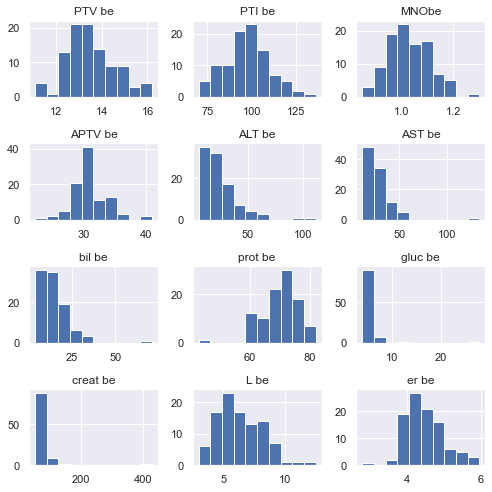

In [13]:
print(df[be_with_null].describe())

plt.rcParams["figure.figsize"] = (7,7)
df[be_with_null].hist()
plt.tight_layout()

In [14]:
df[be_with_null] = df[be_with_null].fillna(df[be_with_null].median())

CEA before - 61 пропущенное значение из 101.

Уровень РЭА может зависеть не только от самого рака, но и от других воспалительных заболеваний в организме. Поэтому, если замена null на медиану (так как выборочное распределение далеко от нормального) не даст хорошего прогностического результата, можно рассмотреть варианты замены на основании близости пациента с другими по воспалительным процессам.

count      61.000000
mean       64.070328
std       176.565630
min         0.100000
25%         2.700000
50%         9.300000
75%        44.200000
max      1000.000000
Name: CEA before, dtype: float64


<AxesSubplot:>

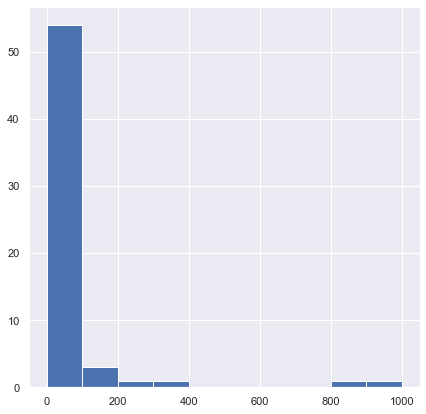

In [15]:
print(df['CEA before'].describe())
df['CEA before'].hist()

In [16]:
df['CEA before'].fillna(df['CEA before'].median(), inplace=True)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 62 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   T                     101 non-null    float64
 1   Number mts            101 non-null    float64
 2   N                     101 non-null    float64
 3   how many positive     101 non-null    float64
 4   mts max size, mm      101 non-null    float64
 5   summ size of all mts  101 non-null    float64
 6   M                     101 non-null    float64
 7   vessel invasion       101 non-null    float64
 8   caps invasion         101 non-null    float64
 9   CEA before            101 non-null    float64
 10  Month till mts        101 non-null    float64
 11  Grade prim            101 non-null    int64  
 12  Age at operation      101 non-null    float64
 13  Sex                   101 non-null    int64  
 14  PV-embol              101 non-null    float64
 15  ХЭПА                  1

# categorical 

In [31]:
cat_df = categorical_raw[:115].copy()
cat_df = cat_df[cat_df['Outcome']!=3]
cat_df['Surname/Name'] = cat_df['Surname/Name'].apply(lambda x: hashlib.sha256(x.encode()).hexdigest())

# quantitative

In [33]:
quant_df= quant_raw[:115].copy()
quant_df['Surname/Name'] = quant_df['Surname/Name'].apply(lambda x: hashlib.sha256(x.encode()).hexdigest())
quant_df = quant_df.iloc[(cat_df['Outcome']!=3).index]

In [34]:
quant_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101 entries, 0 to 114
Data columns (total 88 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Surname/Name          101 non-null    object 
 1   №№                    101 non-null    float64
 2   Med Rec               101 non-null    object 
 3   Age at operation      101 non-null    float64
 4   number of segments    101 non-null    float64
 5   Sex                   101 non-null    object 
 6   how many LN examined  101 non-null    float64
 7   how many positive     101 non-null    float64
 8   Chemo lines           101 non-null    float64
 9   CEA before            61 non-null     float64
 10  summ size of all mts  101 non-null    float64
 11  Number mts            101 non-null    float64
 12  blood loss, ml        101 non-null    float64
 13  mts max size, mm      101 non-null    float64
 14  Рост                  101 non-null    float64
 15  Вес                   1

# other

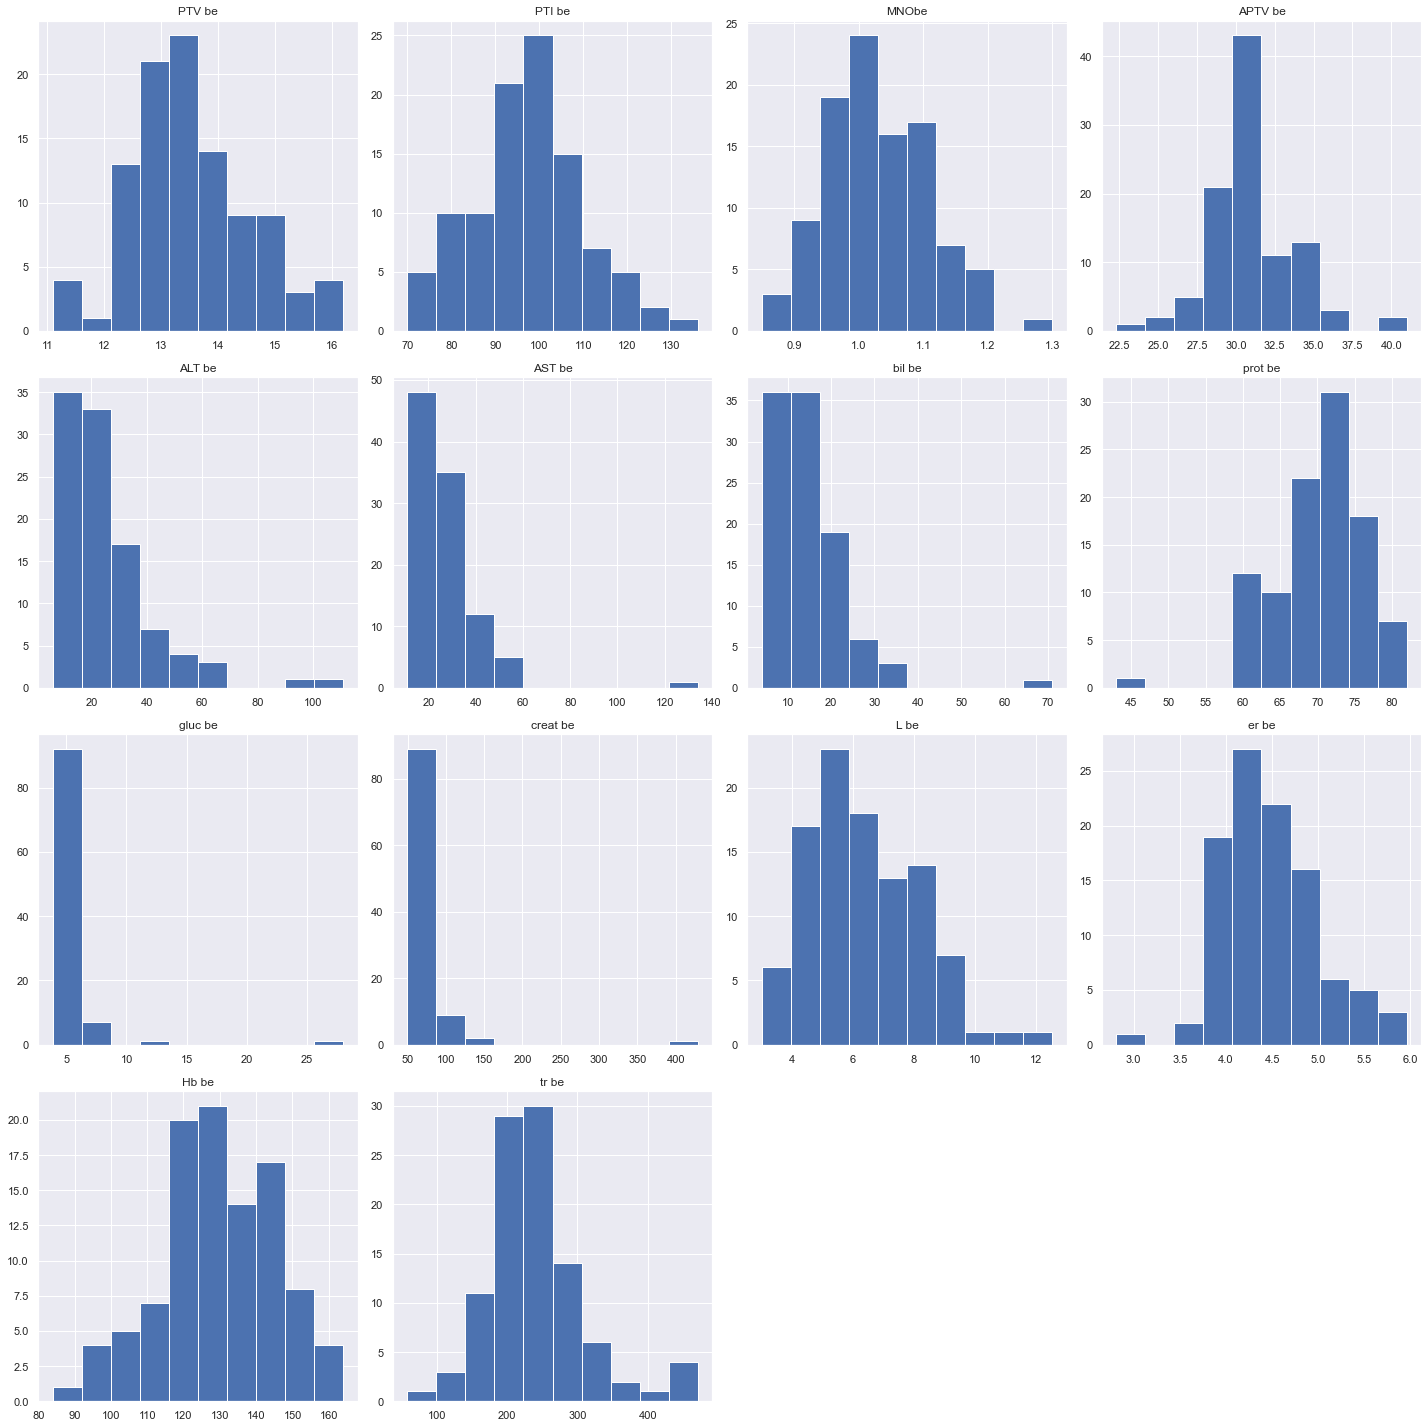

In [21]:
plt.rcParams["figure.figsize"] = (20,20)

df[be_features].hist()
plt.tight_layout()

In [22]:
# df_num = df.loc[:, df.dtypes==float]
# corr = np.abs(df_num.corr())
corr = np.abs(df.corr())

In [ ]:
sns.set_theme(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(50, 50))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, 
            annot=True, fmt=".1f", annot_kws={"fontsize":7},
            # vmax=.3, 
            center=0,
            square=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .5}
            )


In [110]:
# df.corr(method='pearson').style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)

In [185]:
corr_g05 = corr[corr>=0.5]
{k1: {k:v for k,v in v1.items() if pd.notnull(v) and v!=1} for k1, v1 in corr_g05.to_dict().items()}

{'T': {},
 'Number mts': {'summ size of all mts': 0.5274708360628787,
  'Number mts>9': 0.7348783383911283},
 'N': {'how many positive': 0.6051202392240939},
 'how many positive': {'N': 0.6051202392240939},
 'mts max size, mm': {'summ size of all mts': 0.6848646807999598,
  'caps invasion': 0.5029916667769033},
 'summ size of all mts': {'Number mts': 0.5274708360628787,
  'mts max size, mm': 0.6848646807999598},
 'M': {'Month till mts': 0.5165507769105524},
 'vessel invasion': {},
 'caps invasion': {'mts max size, mm': 0.5029916667769033},
 'CEA before': {},
 'Month till mts': {'M': 0.5165507769105524},
 'Grade prim': {},
 'Age at operation': {},
 'Sex': {'Рост': 0.7146214277190889, 'S': 0.5697897290807573},
 'PV-embol': {},
 'ХЭПА': {},
 'RFA before': {},
 'Target ther': {},
 'Hepatic pathology': {},
 'second cancer': {},
 'Diabetis': {},
 'hepar operat': {},
 'Genetic': {},
 'Рост': {'Sex': 0.7146214277190889, 'S': 0.7676327928767425},
 'S': {'Sex': 0.5697897290807573,
  'Рост': 0.76

# tests

In [12]:
# Послеоперационные признаки
tests_v = [
    'MNO', 'hipoprot', 'Hb v', 'PTI-v, %', 'ALT-v', 'bilirub-v', 
    'AST-v', 'Creatin'
]
# Сразу после операции
tests_d0 = [
    'L d0', 'tr d0', 'er d0', 'Ht d0', 'ALT d0', 'amylas d0',
    'AST d0', 'bilir d0', 'album d0', 'prot d0', 'Gluc d0',
    'Creat d0', 'K d0', 'Na d0', 'Ca d0', 'Cl d0', 'PTV d0',
    'PTI d0', 'APTV 0', 'fibrin d0', 'Hb d0'
]

# Первый день после операции
tests_d1 = [
    'ALT d1', 'amyl 1', 'AST 1', 'bilir 1', 'alb 1',
    'prot 1', 'gluc1', 'creat1', 'PTV1', 'PTI 1', 'MNO1',
    'APTV1', 'fibrin1', 'K1', 'Na1', 'Ca1', 'Cl1', 'Hb1',
    'L1', 'er1', 'tr1'
]

# # Шестой день после операции
tests_d6 = [
    'PTV6', 'PTI6', 'MNO6', 'ALT6', 'AST6', 'bilir6', 'prot6',
    'gluc6', 'creat6', 'Hb6', 'er6', 'L6', 'tr 6'
]

# # Какой-то день после операции
tests_be = [
    'PTV be', 'PTI be', 'MNObe', 'APTV be', 'ALT be', 'AST be',
    'bil be', 'prot be', 'gluc be', 'creat be', 'L be', 'er be',
    'Hb be', 'tr be', 'ФВЛЖ'
]

all_tests = {
    'v': tests_v,
    'd0': tests_d0,
    'd1': tests_d1, 
    'd6': tests_d6,
    'be': tests_be
}

In [13]:
test_columns = set()
for test in all_tests.items():
    t = test[1]
    # t.sort()
    for i in t:
        test_columns.add(i)


In [14]:
common_tests = {
    'ALT': ['ALT-v', 'ALT d0', 'ALT d1', 'ALT6', 'ALT be'],
    'APTV': ['APTV1', 'APTV 0', '', '', 'APTV be'],
    'AST': ['AST-v', 'AST d0', 'AST 1', 'AST6', 'AST be'],
    'Ca': ['', 'Ca d0', 'Ca1', '', ''],
    'Cl': ['', 'Cl d0', 'Cl1', '', ''],
    'Creatin': ['Creatin', 'Creat d0', 'creat1', 'creat6', 'creat be'],
    'Hb': ['Hb v', 'Hb d0', 'Hb1', 'Hb6', 'Hb be'],
    'K': ['', 'K d0', 'K1', '', ''],
    'L': ['', 'L d0', 'L1', 'L6', 'L be'],
    'MNO': ['MNO', '', 'MNO1', 'MNO6', 'MNObe'],
    'Na': ['', 'Na d0', 'Na1', '', ''],
    'PTI': ['PTI-v, %', 'PTI d0', 'PTI 1', 'PTI6', 'PTI be'],
    'PTV': ['', 'PTV1', 'PTV d0', 'PTV6', 'PTV be'],
    'alb': ['',  'album d0', 'alb 1', '', ''],
    'amyl': ['', 'amylas d0', 'amyl 1', '', ''],
    'bil': ['bilirub-v', 'bilir d0', 'bilir 1', 'bilir6', 'bil be'],
    'er': ['', 'er d0', 'er1', 'er6', 'er be'],
    'fibrin': ['', 'fibrin d0', 'fibrin1', '', ''],
    'gluc': ['', 'Gluc d0', 'gluc1', 'gluc6', 'gluc be'],
    'prot': ['', 'prot d0', 'prot 1', 'prot6', 'prot be'],
    'tr': ['', 'tr d0', 'tr1', 'tr 6', 'tr be']
}

# Может быть и для мочи, и для крови:
#   gluc : концентрация глюкозы,  
#   L : лейкоциты (?)
#   er : эритроциты (?)
#   Hb : hemoglobin (?)
#   tr : тромбоциты (?)
#   bil : билирубин
#   Na : sodium
#   prot: протеин, 
#   Ca : Urinary calcium
#   Cl : ?


# Общий анализ мочи: 
#   K : potassium
#   Creatin : Creatinine


# Общий анализ крови:
#   alb: Albumin
#   ALT: АЛТ (аланинаминотрансфераза)
#   AST: АСТ (аспартатаминотрансфераза)
#   amyl: Amylase Амилаза
#   fibrin: Фибриноген

# Анализ венозной крови:
# MNO - МНО (международное нормализованное отношение) — 
#       расчетная величина, характеризующая отношение 
#       протромбинового времени и протромбинового индекса.
# PTV - Протромбиновое время (ПТВ) — это время в секундах, 
#       за которое образуется кровяной сгусток, то есть тромб. 
#       - Увеличение ПТВ может быть связано с кровотечениями, 
#         а его сокращение повышает риск тромбозов.
# PTI - Протромбиновый индекс (ПТИ) — значение, равное 
#       отношению ПТВ контрольного образца к ПТВ исследуемого, 
#       выражается в процентах
# APTV - АЧТВ — активированное частичное тромбопластиновое время — 
#       тест для оценки состояния свертывающей системы крови.
#       1. Удлинение АЧТВ у взрослых и детей говорит о гипокоагуляции — 
#       снижении способности к образованию тромбов. Это увеличивает 
#       риск развития кровотечений.
#       2. Укорочение активированного частичного тромбопластинового 
#       времени отражает преобладание гиперкоагуляции — повышенной 
#       свертываемости крови. 

# TrD6/D0

urine_tests = [
    'gluc', 'prot', 'L', 'er', 'bil', 'Na', 'K', 'Ca',
    'Hb', 'Creatin', 
]
# test_columns

In [15]:
# Почистим немного данные перед рисованием графиков
df['PTI d0'].replace(' ', 0, inplace=True)


tests_df = df[test_columns]
tests_obj_cols = tests_df.select_dtypes(object).columns
# for col in tests_obj_cols:
#     cls = dict(tests_df[col].apply(lambda x: type(x)))
#     for val in cls:
#         if 'int' not in str(cls[val]):
#             print(str(val) + str(cls[val]), end='  \n')
# Получилось, что в этих колонках вперемешку int и float => переведем в float
df.loc[:, test_columns] = df[test_columns].astype(float)
df[test_columns].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101 entries, 0 to 114
Data columns (total 78 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   bilir d0   101 non-null    float64
 1   Hb d0      101 non-null    float64
 2   Cl1        98 non-null     float64
 3   PTI 1      100 non-null    float64
 4   tr 6       100 non-null    float64
 5   bilir6     99 non-null     float64
 6   AST-v      101 non-null    float64
 7   amyl 1     100 non-null    float64
 8   alb 1      101 non-null    float64
 9   Hb1        100 non-null    float64
 10  ФВЛЖ       101 non-null    float64
 11  gluc1      101 non-null    float64
 12  tr be      101 non-null    float64
 13  Creatin    101 non-null    float64
 14  Hb v       101 non-null    float64
 15  fibrin d0  101 non-null    float64
 16  ALT d0     101 non-null    float64
 17  amylas d0  101 non-null    float64
 18  AST 1      101 non-null    float64
 19  creat1     101 non-null    float64
 20  tr1       

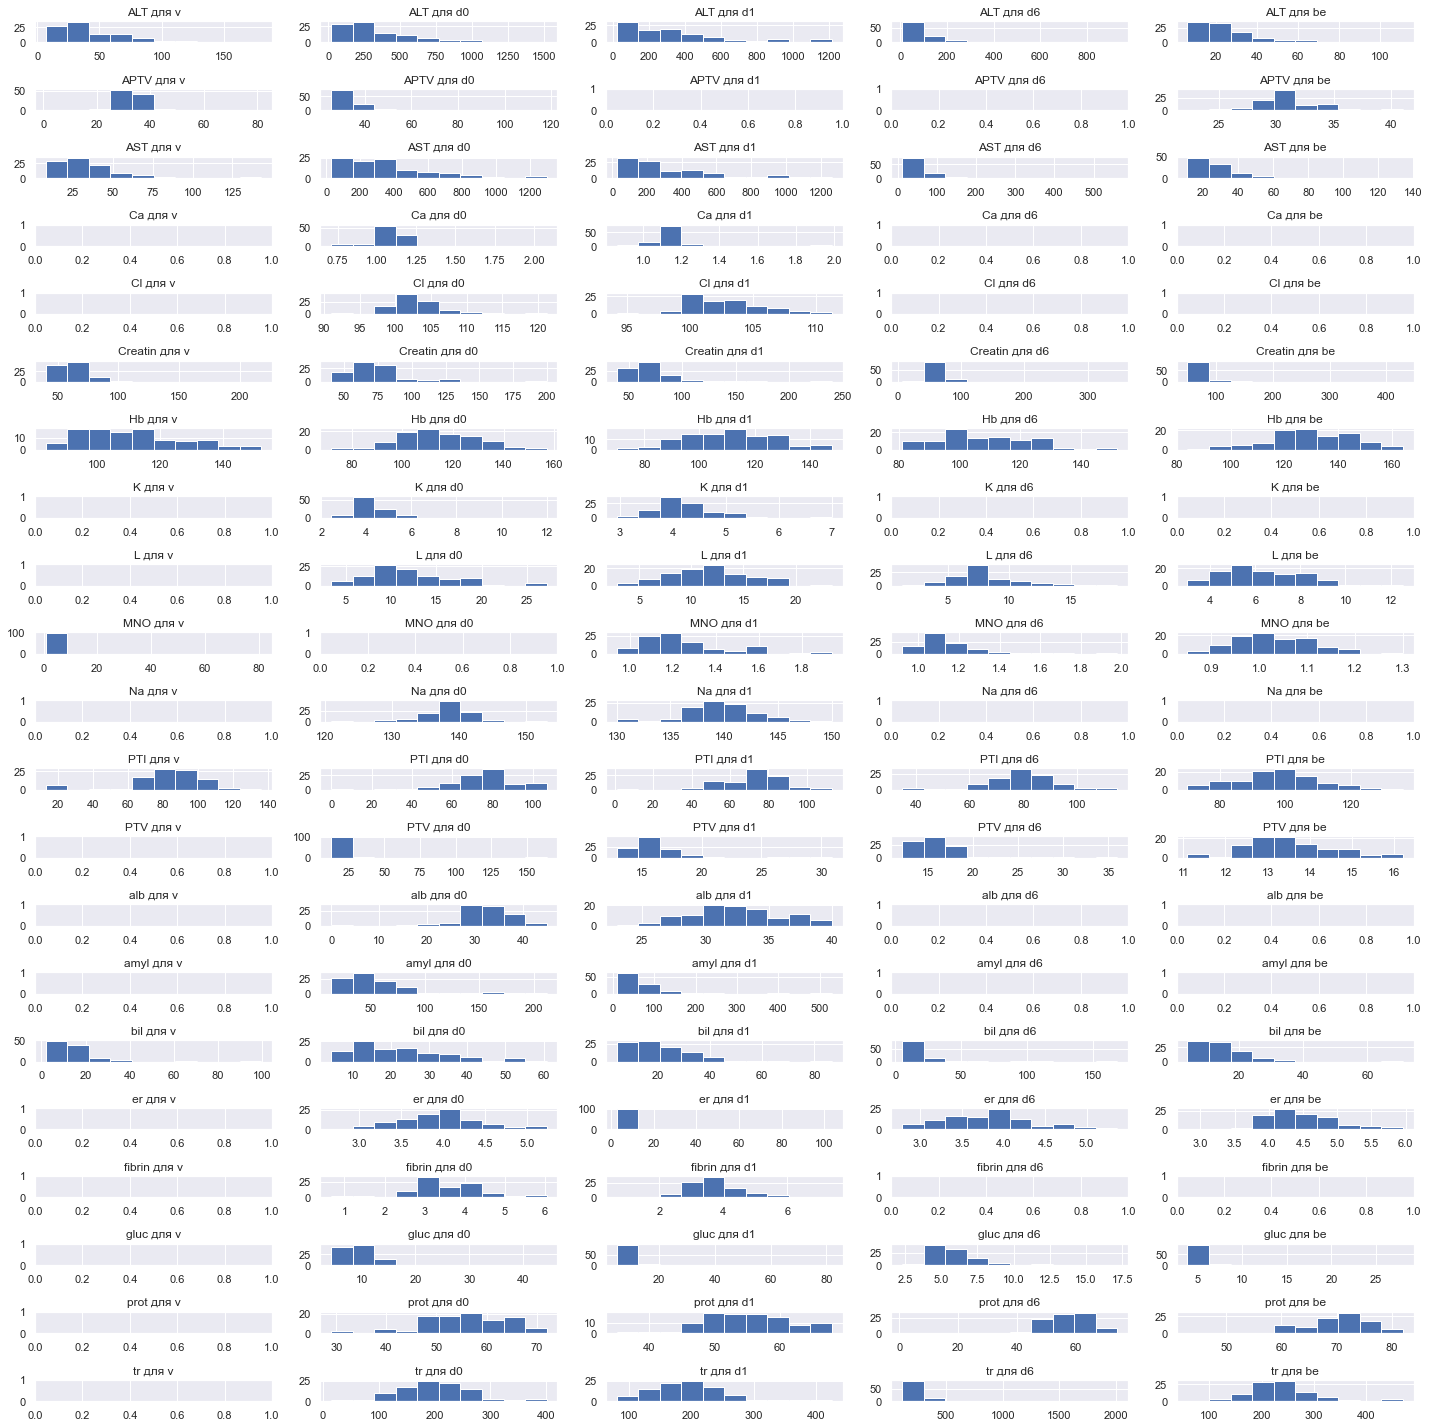

In [19]:
plt.rcParams["figure.figsize"] = (20,20)

# графики распределения результатов анализа (ось игрек) для разных дней (ось икс)
fig, axes = plt.subplots(nrows=len(common_tests), ncols=len(all_tests))
sns.set_theme(style='darkgrid')

n = 1
for i, ax in enumerate(axes.flat):
    test = list(common_tests.keys())[int(i / len(all_tests))]
    day = int(i%len(all_tests))
    ax.set(title= test + ' для ' + list(all_tests.keys())[day]) # , xticks=[], yticks=[]
    if common_tests[test][day] != '':
        ax.hist(df[common_tests[test][day]].astype(float))
    
    n += 1


plt.tight_layout()
plt.show()


# Base model with all numerical features 

In [18]:
df.Outcome.value_counts()

1    62
0    39
Name: Outcome, dtype: int64

In [19]:
df = df.astype(float)

<AxesSubplot:>

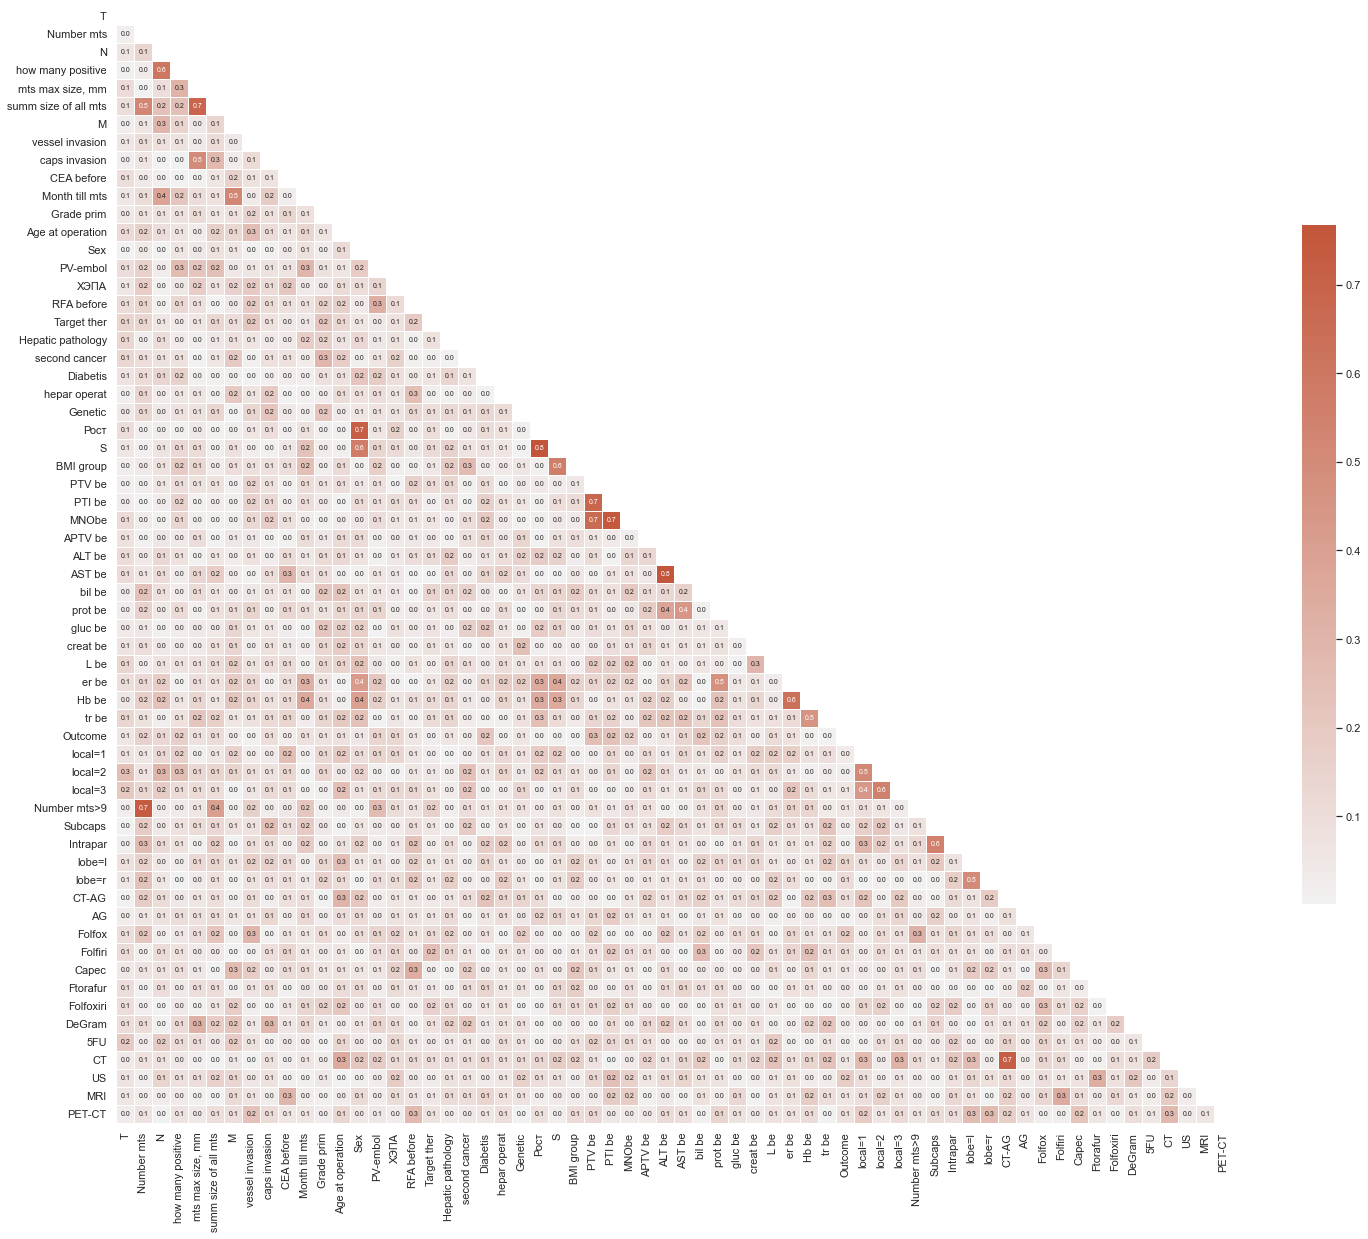

In [108]:
corr = np.abs(df.corr())

sns.set_theme(style="white")

mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(25, 25))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, 
            annot=True, fmt=".1f", annot_kws={"fontsize":7},
            # vmax=.3, 
            center=0,
            square=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .5}
            )


In [20]:
(np.abs(df.corr(method='spearman')['Outcome']).sort_values(ascending=False))[1:]

PTV be       0.218248
Diabetis     0.216432
Folfox       0.188700
PTI be       0.182188
US           0.179209
               ...   
Hb be        0.007330
AG           0.006498
S            0.003139
BMI group    0.003070
tr be        0.002791
Name: Outcome, Length: 61, dtype: float64

In [21]:
feats = list(set(df.columns)-set(be_features+[target]))

In [22]:
quant_feat = [ # 'N', 'Grade prim', 'T', 'BMI group', 'M'
    'Month till mts', 'Age at operation', 
    'S', 'Number mts', 'CEA before', 'Рост',
    'summ size of all mts', 'mts max size, mm', 
    'how many positive']

cat_feat = list(set(feats)-set(quant_feat))

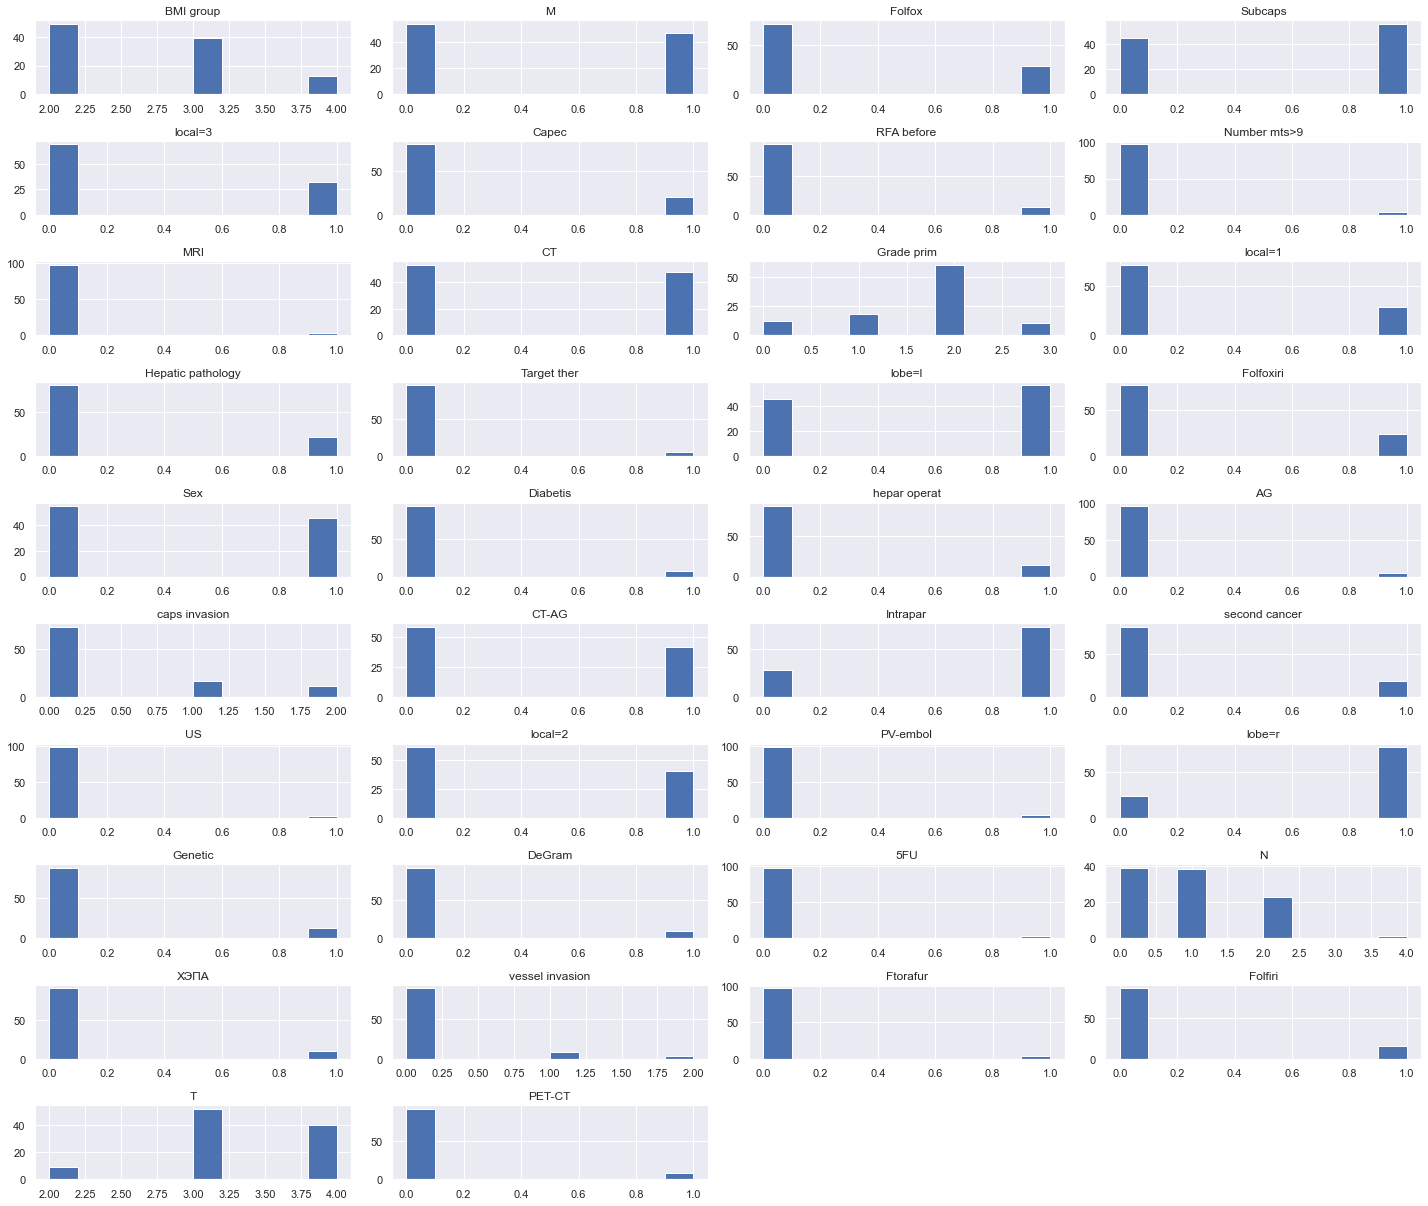

In [23]:
plt.rcParams["figure.figsize"] = (20,20)
df[cat_feat].hist(layout=(12, 4))
plt.tight_layout()

In [84]:
factors = [
    'how many positive', # node-positive primary how many positive   hylar L/N
    'Month till mts', # Disease-free interval <12 months
    'Number mts', # >1 hepatic tumor 
    'CEA before', # Preoperative CEA level >200 ng/mL 
    'mts max size, mm' # Size of largest hepatic tumor >5cm
]

perm_be_imp = ['bil be', 'PTI be', 'MNObe', 'prot be']

perm_all_imp = [
    'bil be', 'PTI be', 'MNObe', 'prot be', 
    'caps invasion', 'er be', 'creat be', 
    'CT-AG', 'Intrapar', 'L be', 
    'Month till mts', 'mts max size, mm'
]

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(
    df.drop(columns=['Outcome']), 
    df['Outcome'],
    stratify=df['Outcome'],
    test_size=0.3, 
    random_state=42)


In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

model = RandomForestClassifier(
            random_state=1, 
            n_estimators=200,
            max_depth=3, 
            min_samples_split=5, 
            max_features='sqrt')
model.fit(xtrain, ytrain)

ytrain_pred = model.predict(xtrain)
ytest_pred = model.predict(xtest)

print('Train:')
print(roc_auc_score(ytrain, ytrain_pred))
print('Test:')
print(roc_auc_score(ytest, ytest_pred))

print('train accuracy: ', model.score(xtrain, ytrain))
print('test accuracy: ', model.score(xtest, ytest))

# clf = RandomForestClassifier(random_state=1, max_depth=2, class_weight='balanced') # max_iter=1000
# print('Recall:', list(cross_val_score(clf, 
#     xtrain, ytrain, 
#     cv=3,
#     scoring='recall')))
# print('Precision:', list(cross_val_score(clf, 
#     xtrain, ytrain, 
#     cv=3,
    # scoring='f1')))

Train:
0.8888888888888888
Test:
0.625
train accuracy:  0.9142857142857143
test accuracy:  0.7096774193548387


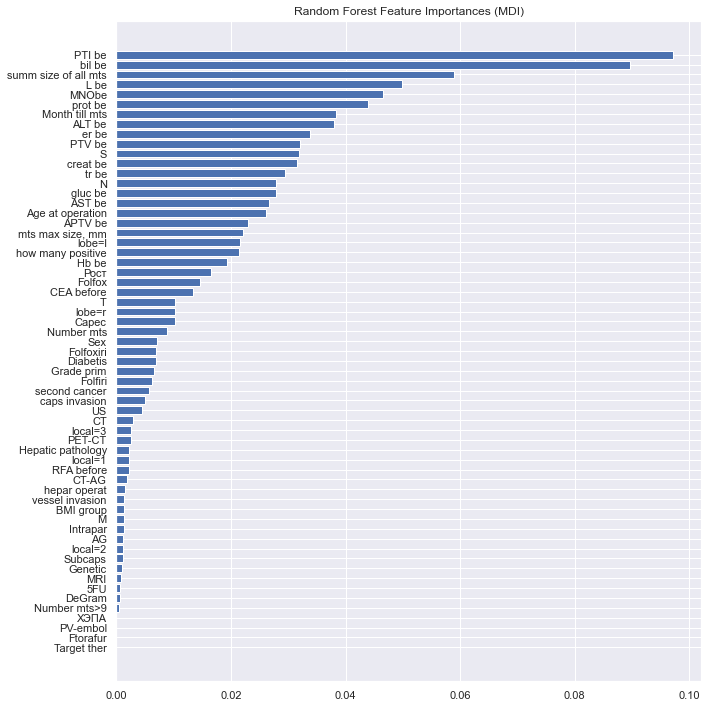

In [43]:
# random forest feature importances
plt.rcParams["figure.figsize"] = (10,10)

tree_feature_importances = model.feature_importances_
sorted_idx = tree_feature_importances.argsort()
feature_names = xtrain.columns

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots()
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()

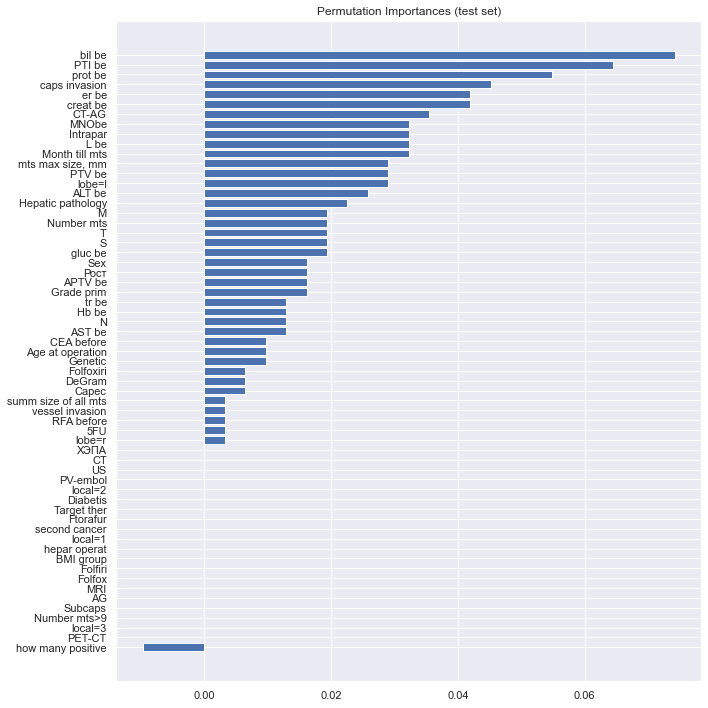

In [44]:
# permutation importance features
plt.rcParams["figure.figsize"] = (10, 10)

from sklearn.inspection import permutation_importance
result = permutation_importance(
    model, xtest, ytest, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots()
ax.barh(y_ticks, np.mean(result.importances, axis=1)[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

In [45]:
ordered_impr = list(feature_names[sorted_idx])
ordered_impr.reverse()
ordered_impr

['bil be',
 'PTI be',
 'prot be',
 'caps invasion',
 'er be',
 'creat be',
 'CT-AG',
 'MNObe',
 'Intrapar',
 'L be',
 'Month till mts',
 'mts max size, mm',
 'PTV be',
 'lobe=l',
 'ALT be',
 'Hepatic pathology',
 'M',
 'Number mts',
 'T',
 'S',
 'gluc be',
 'Sex',
 'Рост',
 'APTV be',
 'Grade prim',
 'tr be',
 'Hb be',
 'N',
 'AST be',
 'CEA before',
 'Age at operation',
 'Genetic',
 'Folfoxiri',
 'DeGram',
 'Capec',
 'summ size of all mts',
 'vessel invasion',
 'RFA before',
 '5FU',
 'lobe=r',
 'ХЭПА',
 'CT',
 'US',
 'PV-embol',
 'local=2',
 'Diabetis',
 'Target ther',
 'Ftorafur',
 'second cancer',
 'local=1',
 'hepar operat',
 'BMI group',
 'Folfiri',
 'Folfox',
 'MRI',
 'AG',
 'Subcaps',
 'Number mts>9',
 'local=3',
 'PET-CT',
 'how many positive']

# Калибровка

In [46]:
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer

# для количественных
log_skewed_pipe = Pipeline([
    ('scaler', PowerTransformer()), 
])

np.random.seed(42)
cv = 3

lr = Pipeline([
        ('tf', log_skewed_pipe),
        ('lg', LogisticRegression(C=0.01))
])

lr_calib = Pipeline([
        ('tf', log_skewed_pipe),
        ('cali lg', CalibratedClassifierCV(LogisticRegression(C=0.01), cv=cv, method="sigmoid"))
])

gnb = Pipeline([
        ('tf', log_skewed_pipe),
        ('gnb', GaussianNB())
])
gnb_calib = Pipeline([
        ('tf', log_skewed_pipe),
        ('cali gnb', CalibratedClassifierCV(GaussianNB(), cv=cv, method="sigmoid"))
])

rf = Pipeline([
        ('tf', log_skewed_pipe),
        ('rf', RandomForestClassifier(n_estimators=100))
])
rf_calib = Pipeline([
        ('tf', log_skewed_pipe),
        ('cali rf', CalibratedClassifierCV(RandomForestClassifier(n_estimators=100), cv=cv, method="sigmoid"))
])

gb = Pipeline([
        ('tf', log_skewed_pipe),
        ('rf', GradientBoostingClassifier(n_estimators=100))
])
gb_calib = Pipeline([
        ('tf', log_skewed_pipe),
        ('cali gb', CalibratedClassifierCV(GradientBoostingClassifier(n_estimators=100), cv=cv, method="sigmoid"))
])



# gnb_isotonic = CalibratedClassifierCV(gnb, cv=cv, method="isotonic") так как наблюдение <1000
# gnb_sigmoid = CalibratedClassifierCV(gnb, cv=cv, method="sigmoid")
# rfc_isotonic = CalibratedClassifierCV(rfc, cv=cv, method="isotonic")
# rfc_sigmoid = CalibratedClassifierCV(rf, cv=cv, method="sigmoid")


clf_list = [
    (lr, "Logistic"),
    (gnb, "Naive Bayes"),
    (rf, "Random forest"),
    (gb, "Gradient Boosting"),
    (lr_calib, "Logistic + Sigmoid"),
    (gnb_calib, "Naive Bayes + Sigmoid"),
    (rf_calib, "Random forest + Sigmoid"),
    (gb_calib, "Gradient Boosting + Sigmoid"),
]


In [68]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    brier_score_loss,
    log_loss,
    roc_auc_score,
)

def extended_calibration_plot(num, X_train, X_test, y_train, y_test):
    
    temp = pd.DataFrame(columns=['score_name', 'score', 'num_features', 'clf'])
    # создаем таблицу графиков
    # plt.figure(figsize=(9, 9))
    # ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    # ax1.grid()
    # ax2 = plt.subplot2grid((3, 1), (2, 0))
    # ax2.grid()
    # ax1.plot([0, 1], [0, 1], "k:", label="Идеальная калибровка")

    # обучаем конвейеры
    for pipe, name in clf_list:

        pipe.fit(X_train, y_train)

        # записываем вероятности положительного класса
        if hasattr(pipe, 'predict_proba'):
            prob_pos = pipe.predict_proba(X_test)[:, 1]

        else: # используем решающую функцию 
            prob_pos = pipe.decision_function(X_test) 
            prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min()) 

        # получаем фактические и спрогнозированные вероятности 
        fraction_of_positives, mean_predicted_value = calibration_curve(
            y_test, prob_pos, n_bins=10)
            
        # ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
        #         label="%s" % (name, )) # строим гистограмму
        # ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
        #         histtype='step', lw=2)

        # вычисляем оценку Брайера, AUC и логистическую функцию потерь
        brier_score = brier_score_loss(y_test, prob_pos) 
        auc_score = roc_auc_score(y_test, prob_pos) 
        log_loss_score = log_loss(y_test, prob_pos)
        # печатаем название метода, оценку Брайера, AUC 
        # # и логистическую функцию потерь
        print("%s:" % name)
        print("\tОценка Брайера: %1.3f" % (brier_score))
        print("\tAUC: %1.3f" % (auc_score))
        print("\tЛогистическая функция потерь: %1.3f" % (log_loss_score))

        temp = temp.append([{'score_name':'Brier score', 'score':brier_score, 'num_features':num, 'clf':name},
                            {'score_name':'AUC score', 'score':auc_score, 'num_features':num, 'clf':name},
                            {'score_name':'Logloss score', 'score':log_loss_score, 'num_features':num, 'clf':name}], ignore_index=True)

    # ax1.set_ylabel("Доля наблюдений положительного класса") # задаем диапазон значений оси y
    # ax1.set_ylim([-0.05, 1.05])
    # ax1.legend(loc="lower right")
    # ax1.set_title("График калибровки (кривая надежности) и гистограмма") # задаем заголовок оси x
    # ax2.set_xlabel("Усредненное спрогнозированное значение")
    # ax2.set_ylabel("Частота")
    # ax2.legend(loc="upper center", ncol=2)
    # plt.tight_layout()

    # plt.show()

    return temp


temp = pd.DataFrame(columns=['score', 'num_features', 'clf'])

for i in range(len(ordered_impr)):
    features = ordered_impr[:i+1]
    print('Number of features = ', i+1, '\n', features)
    res = extended_calibration_plot(i+1, xtrain[features], xtest[features], ytrain, ytest)
    temp = pd.concat([temp, res], axis=0)

temp

Number of features =  1 
 ['bil be']
Logistic:
	Оценка Брайера: 0.238
	AUC: 0.518
	Логистическая функция потерь: 0.670
Naive Bayes:
	Оценка Брайера: 0.234
	AUC: 0.575
	Логистическая функция потерь: 0.662
Random forest:
	Оценка Брайера: 0.290
	AUC: 0.493
	Логистическая функция потерь: 5.977
Gradient Boosting:
	Оценка Брайера: 0.319
	AUC: 0.401
	Логистическая функция потерь: 1.108
Logistic + Sigmoid:
	Оценка Брайера: 0.249
	AUC: 0.518
	Логистическая функция потерь: 0.697
Naive Bayes + Sigmoid:
	Оценка Брайера: 0.234
	AUC: 0.570
	Логистическая функция потерь: 0.661
Random forest + Sigmoid:
	Оценка Брайера: 0.219
	AUC: 0.693
	Логистическая функция потерь: 0.629
Gradient Boosting + Sigmoid:
	Оценка Брайера: 0.221
	AUC: 0.680
	Логистическая функция потерь: 0.632
Number of features =  2 
 ['bil be', 'PTI be']
Logistic:
	Оценка Брайера: 0.234
	AUC: 0.579
	Логистическая функция потерь: 0.661
Naive Bayes:
	Оценка Брайера: 0.253
	AUC: 0.561
	Логистическая функция потерь: 0.708
Random forest:
	Оце

,score,num_features,clf,score_name
0,0.238251,1,Logistic,Brier score
1,0.517544,1,Logistic,AUC score
2,0.669624,1,Logistic,Logloss score
3,0.233832,1,Naive Bayes,Brier score
4,0.574561,1,Naive Bayes,AUC score
...,...,...,...,...
19,0.535088,61,Random forest + Sigmoid,AUC score
20,0.675197,61,Random forest + Sigmoid,Logloss score
21,0.232554,61,Gradient Boosting + Sigmoid,Brier score
22,0.587719,61,Gradient Boosting + Sigmoid,AUC score


In [87]:
temp.groupby(by=['score_name']).count()

,score,num_features,clf
score_name,,,
AUC score,488,488,488
Brier score,488,488,488
Logloss score,488,488,488


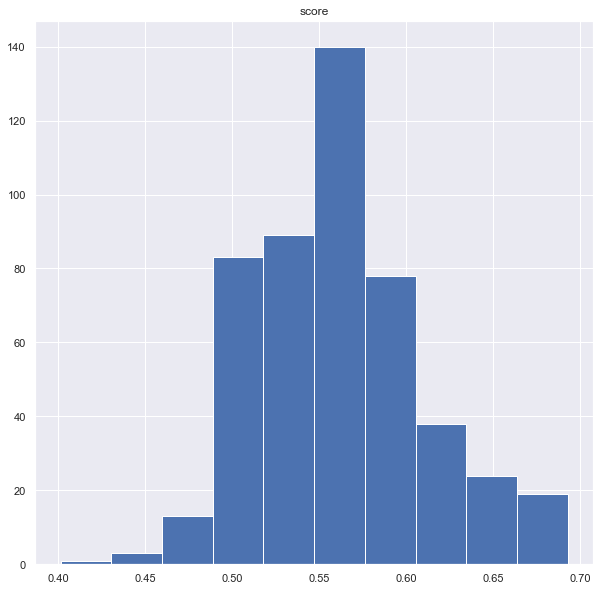

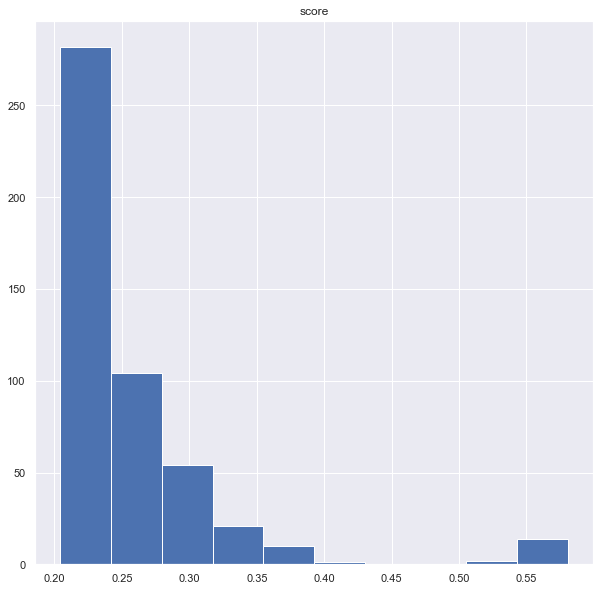

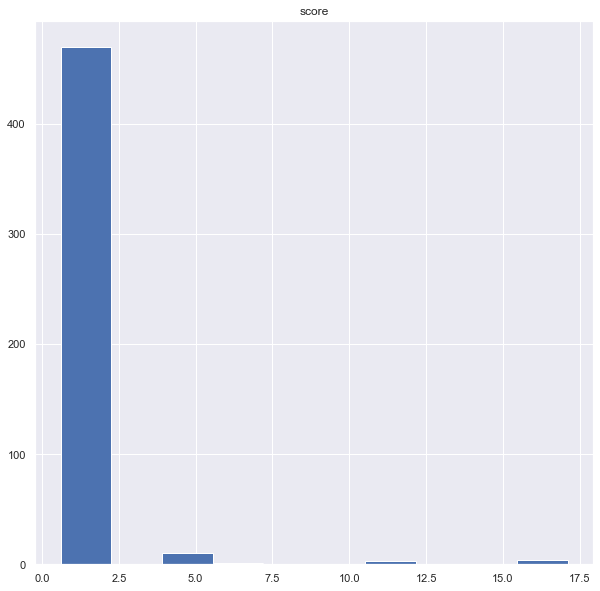

In [112]:
hs = temp.groupby(by=['score_name']).hist()

In [127]:
tt = temp.groupby(['num_features', 'clf', 'score_name'])['score'].first().unstack()

In [135]:
tt.sort_values(by=['Brier score', 'AUC score'], ascending=[True, False])

score_name                                AUC score  Brier score  \
num_features clf                                                   
4            Random forest + Sigmoid       0.662281     0.204444   
5            Gradient Boosting + Sigmoid   0.684211     0.209193   
4            Gradient Boosting + Sigmoid   0.679825     0.209950   
3            Random forest + Sigmoid       0.649123     0.210333   
             Gradient Boosting + Sigmoid   0.653509     0.212557   
...                                             ...          ...   
57           Naive Bayes                   0.552632     0.580632   
58           Naive Bayes                   0.557018     0.580645   
59           Naive Bayes                   0.557018     0.580645   
60           Naive Bayes                   0.557018     0.580645   
61           Naive Bayes                   0.543860     0.580645   

score_name                                Logloss score  
num_features clf                                         
4            Random forest + Sigmoid           0.601490  
5            Gradient Boosting + Sigmoid       0.606154  
4            Gradient Boosting + Sigmoid       0.612010  
3            Random forest + Sigmoid           0.614176  
             Gradient Boosting + Sigmoid       0.618328  
...                                                 ...  
57           Naive Bayes                      10.774468  
58           Naive Bayes                      17.038358  
59           Naive Bayes                      17.086331  
60           Naive Bayes                      17.052907  
61           Naive Bayes                      17.115550  

[488 rows x 3 columns]

In [134]:
tt.sort_values(by=['AUC score', 'Brier score'], ascending=[False, True])

,score_name,AUC score,Brier score,Logloss score
num_features,clf,,,
1,Random forest + Sigmoid,0.692982,0.219001,0.629106
11,Gradient Boosting,0.692982,0.284740,1.005014
34,Gradient Boosting,0.684211,0.231039,0.697767
31,Gradient Boosting,0.684211,0.237111,0.709780
35,Gradient Boosting,0.684211,0.252561,0.786478
...,...,...,...,...
47,Random forest,0.462719,0.250190,0.697136
25,Naive Bayes + Sigmoid,0.447368,0.253459,0.700837
27,Naive Bayes + Sigmoid,0.442982,0.249371,0.692542


другой прогон - с perm_all_imp

# Оптимальная модель

In [141]:
five_feats = ordered_impr[:5] # ['bil be', 'PTI be', 'prot be', 'caps invasion', 'er be']

from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer

# для количественных
log_skewed_pipe = Pipeline([
    ('scaler', PowerTransformer()), 
])

np.random.seed(42)

cv = 3
rf = Pipeline([
        ('tf', log_skewed_pipe),
        ('rf', RandomForestClassifier(n_estimators=100))
])
rf_calib = Pipeline([
        ('tf', log_skewed_pipe),
        ('cali rf', CalibratedClassifierCV(RandomForestClassifier(n_estimators=100), cv=cv, method="sigmoid"))
])

gb = Pipeline([
        ('tf', log_skewed_pipe),
        ('gb', GradientBoostingClassifier(n_estimators=100))
])
gb_calib = Pipeline([
        ('tf', log_skewed_pipe),
        ('cali gb', CalibratedClassifierCV(GradientBoostingClassifier(n_estimators=100), cv=cv, method="sigmoid"))
])


clf_list = [
    (rf, "Random Forest"),
    (rf_calib, "Random Forest + Sigmoid"),
    (gb, "Gradient Boosting"),
    (gb_calib, "Gradient Boosting + Sigmoid"),
]


Random Forest:
	Оценка Брайера: 0.208
	AUC: 0.675
	Логистическая функция потерь: 0.620
Random Forest + Sigmoid:
	Оценка Брайера: 0.208
	AUC: 0.645
	Логистическая функция потерь: 0.609
Gradient Boosting:
	Оценка Брайера: 0.287
	AUC: 0.654
	Логистическая функция потерь: 0.987
Gradient Boosting + Sigmoid:
	Оценка Брайера: 0.210
	AUC: 0.684
	Логистическая функция потерь: 0.606


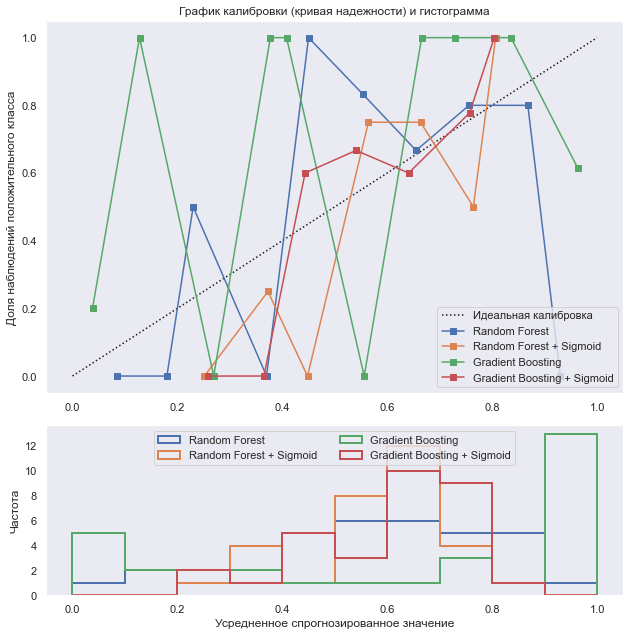

In [142]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    brier_score_loss,
    log_loss,
    roc_auc_score,
)

def extended_calibration_plot(X_train, X_test, y_train, y_test):
    # создаем таблицу графиков
    plt.figure(figsize=(9, 9))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax1.grid()
    ax2 = plt.subplot2grid((3, 1), (2, 0))
    ax2.grid()
    ax1.plot([0, 1], [0, 1], "k:", label="Идеальная калибровка")
    # обучаем конвейеры
    for pipe, name in clf_list:
        pipe.fit(X_train, y_train)
        # записываем вероятности положительного класса
        if hasattr(pipe, 'predict_proba'):
            prob_pos = pipe.predict_proba(X_test)[:, 1]
        else: # используем решающую функцию 
            prob_pos = pipe.decision_function(X_test) 
            prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min()) 
        # получаем фактические и спрогнозированные вероятности 
        fraction_of_positives, mean_predicted_value = calibration_curve(
            y_test, prob_pos, n_bins=10)
        # строим график калибровки
        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                label="%s" % (name, )) # строим гистограмму
        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                histtype='step', lw=2)
        # вычисляем оценку Брайера, AUC и логистическую функцию потерь
        brier_score = brier_score_loss(y_test, prob_pos) 
        auc_score = roc_auc_score(y_test, prob_pos) 
        log_loss_score = log_loss(y_test, prob_pos)
        # печатаем название метода, оценку Брайера, AUC 
        # # и логистическую функцию потерь
        print("%s:" % name)
        print("\tОценка Брайера: %1.3f" % (brier_score))
        print("\tAUC: %1.3f" % (auc_score))
        print("\tЛогистическая функция потерь: %1.3f" % (log_loss_score))
            # задаем заголовок оси y

    ax1.set_ylabel("Доля наблюдений положительного класса") # задаем диапазон значений оси y
    ax1.set_ylim([-0.05, 1.05])
    # задаем расположение легенды
    ax1.legend(loc="lower right")
    # задаем заголовок графика
    ax1.set_title("График калибровки (кривая надежности) и гистограмма") # задаем заголовок оси x
    ax2.set_xlabel("Усредненное спрогнозированное значение")
    # задаем заголовок оси y
    ax2.set_ylabel("Частота")
    # задаем расположение легенды
    ax2.legend(loc="upper center", ncol=2)
    # выполняем укладку
    plt.tight_layout()


extended_calibration_plot(xtrain[five_feats], xtest[five_feats], ytrain, ytest)

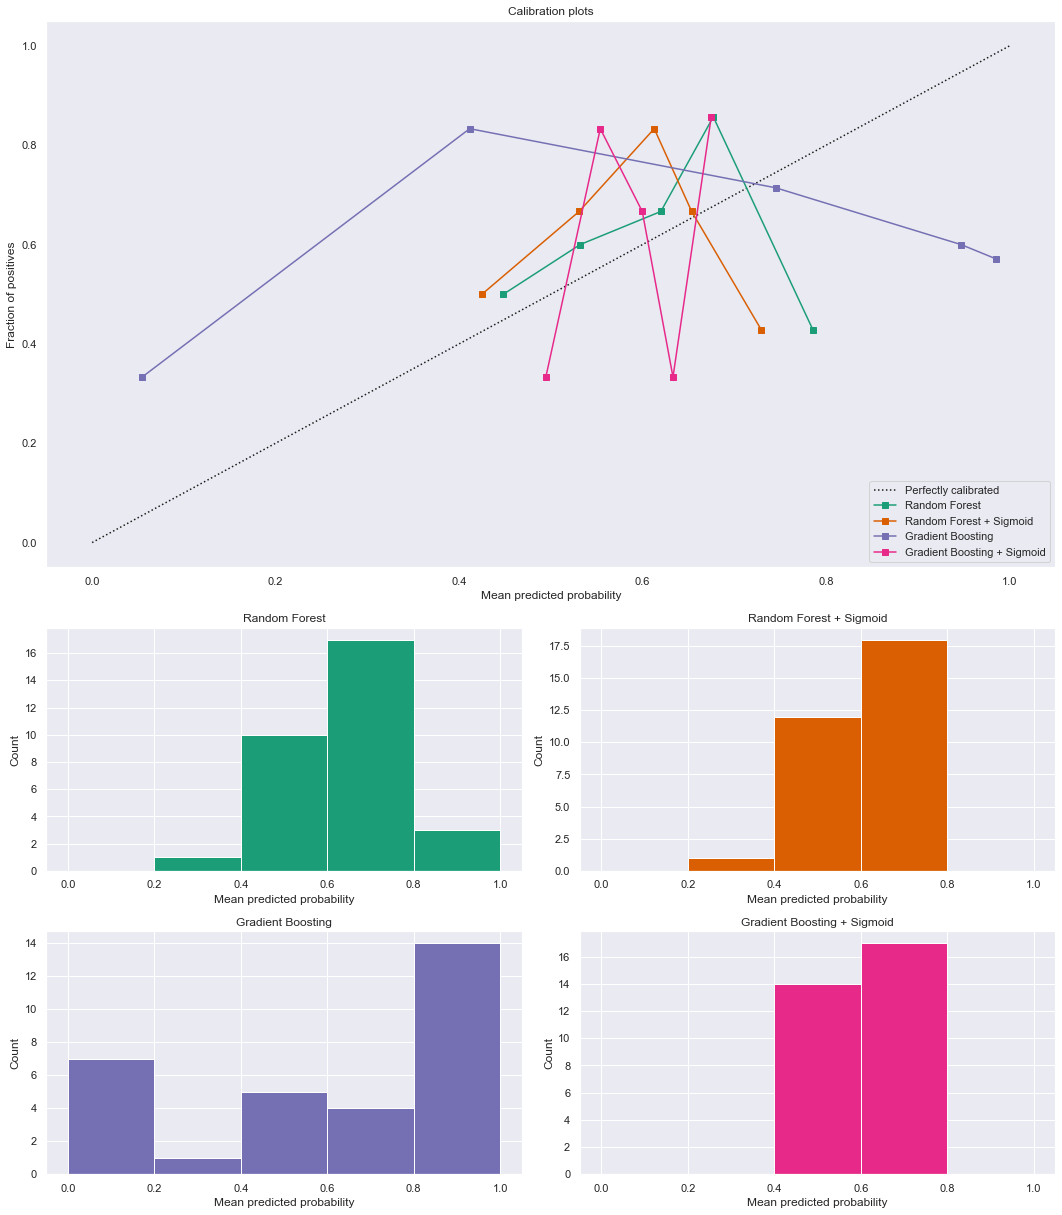

In [143]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(15, 25))
gs = GridSpec(6, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(xtrain, ytrain)
    display = CalibrationDisplay.from_estimator(
        clf,
        xtest,
        ytest,
        n_bins=5,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
        strategy='quantile'
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1), (4, 0), (4, 1), (5, 0)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=5,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()


In [144]:
from collections import defaultdict

import pandas as pd

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    brier_score_loss,
    log_loss,
    roc_auc_score,
)

scores = defaultdict(list)
for i, (clf, name) in enumerate(clf_list):
    clf.fit(xtrain, ytrain)
    y_prob = clf.predict_proba(xtest)
    y_pred = clf.predict(xtest)
    scores["Classifier"].append(name)

    for metric in [brier_score_loss, log_loss]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(ytest, y_prob[:, 1]))

    for metric in [accuracy_score, precision_score, recall_score, f1_score, roc_auc_score]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(ytest, y_pred))

    score_df = pd.DataFrame(scores).set_index("Classifier")
    score_df.round(decimals=3)

score_df


,Brier loss,Log loss,Accuracy,Precision,Recall,F1,Roc auc
Classifier,,,,,,,
Random Forest,0.228645,0.648693,0.677419,0.695652,0.842105,0.761905,0.629386
Random Forest + Sigmoid,0.239702,0.674816,0.645161,0.666667,0.842105,0.744186,0.587719
Gradient Boosting,0.309744,1.069027,0.580645,0.650000,0.684211,0.666667,0.550439
Gradient Boosting + Sigmoid,0.232234,0.656662,0.580645,0.607143,0.894737,0.723404,0.489035


In [94]:
print(rfc_sigmoid.base_estimator.predict_proba(xtest)[:, 1])
rfc_sigmoid.base_estimator.predict(xtest)

[0.66 0.3  0.68 0.54 0.86 0.69 0.59 0.76 0.61 0.52 0.7  0.75 0.38 0.44
 0.97 0.76 0.86 0.74 0.81 0.62 0.39 0.73 0.73 0.63 0.52 0.49 0.49 0.46
 0.48 0.48 0.89]


array([1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1.])

train 1.0
test 0.6451612903225806


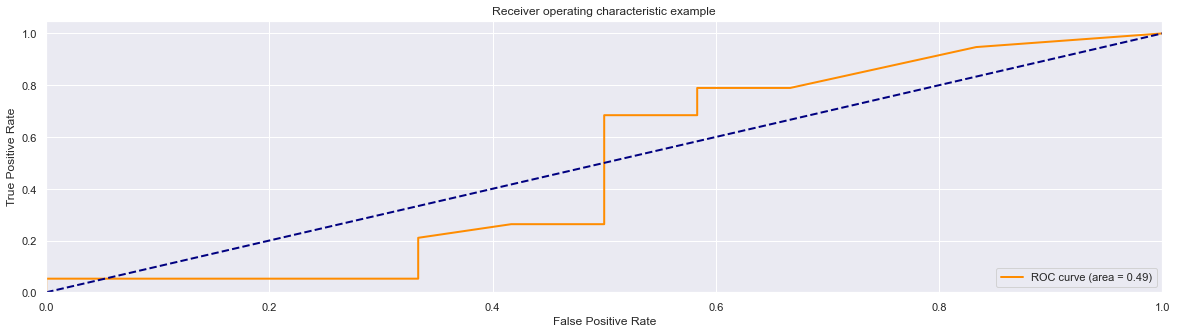

In [290]:
print('train', rfc_sigmoid.base_estimator.score(xtrain_scaled, ytrain))
print('test', rfc_sigmoid.base_estimator.score(xtest_scaled, ytest))

ytrain_pred = rfc_sigmoid.base_estimator.predict(xtrain_scaled)
ytest_pred = rfc_sigmoid.base_estimator.predict_proba(xtest_scaled)[:, 1]

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score


roc_auc = dict()
fpr, tpr, _ = roc_curve(ytest, ytest_pred)
roc_auc = auc(fpr, tpr)

# Compute micro-average ROC curve and ROC area
fpr1, tpr1, _ = roc_curve(ytest.ravel(), ytest_pred.ravel())
roc_auc1 = auc(fpr1, tpr1)


plt.figure()
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=2,
    label="ROC curve (area = %0.2f)" % roc_auc1,
)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()


# dimensionality reduction

C:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


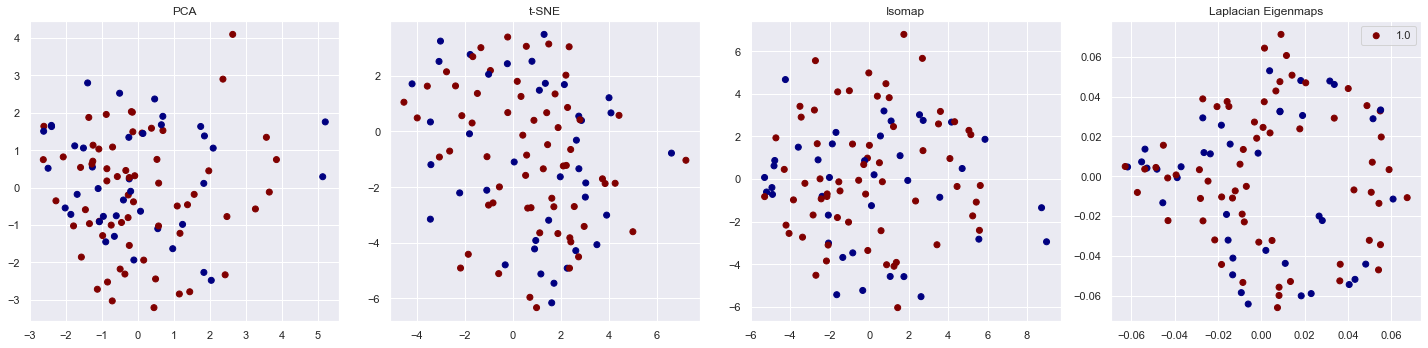

In [264]:
from sklearn.manifold import TSNE, Isomap, SpectralEmbedding
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
tsne = TSNE(n_components=2)
isomap = Isomap(n_components=2)
se = SpectralEmbedding(n_components=2)

algs = [
    ('PCA', pca), ('t-SNE', tsne),
    ('Isomap', isomap), ('Laplacian Eigenmaps', se)
]


plt.rcParams["figure.figsize"] = (20,5)
sns.set_theme(style='darkgrid')
fig, axes = plt.subplots(1, 4)

for item in enumerate(algs):
    x_embedd = item[1][1].fit_transform((pd.concat([xtrain_scaled, xtest_scaled])[quant_feat]))
    axes[item[0]].scatter(x_embedd[:, 0], x_embedd[:, 1], c=df['Outcome'], cmap='jet', marker='o')
    axes[item[0]].set_title(item[1][0])

plt.tight_layout()
plt.legend(df['Outcome'])
plt.show()

In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 62 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   T                     101 non-null    float64
 1   Number mts            101 non-null    float64
 2   N                     101 non-null    float64
 3   how many positive     101 non-null    float64
 4   mts max size, mm      101 non-null    float64
 5   summ size of all mts  101 non-null    float64
 6   M                     101 non-null    float64
 7   vessel invasion       101 non-null    float64
 8   caps invasion         101 non-null    float64
 9   CEA before            101 non-null    float64
 10  Month till mts        101 non-null    float64
 11  Grade prim            101 non-null    int64  
 12  Age at operation      101 non-null    float64
 13  Sex                   101 non-null    int64  
 14  PV-embol              101 non-null    float64
 15  ХЭПА                  1

In [98]:
df['Outcome'].value_counts()

1    62
0    39
Name: Outcome, dtype: int64

C:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


Target looks like classification
Showing only top 10 of 21 continuous features


C:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\dabl\plot\utils.py:632: UserWarning: Dropped 1 outliers in column bil be.
  warn("Dropped {} outliers in column {}.".format(
C:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\dabl\plot\utils.py:632: UserWarning: Dropped 1 outliers in column prot be.
  warn("Dropped {} outliers in column {}.".format(


Linear Discriminant Analysis training set score: 0.709
Showing only top 10 of 33 categorical features


C:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\dabl\plot\utils.py:374: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(
C:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\dabl\plot\utils.py:374: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(
C:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\dabl\plot\utils.py:374: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


[[<Figure size 1440x288 with 10 Axes>,
  <Figure size 1152x288 with 4 Axes>,
  <Figure size 1152x288 with 4 Axes>,
  <Figure size 720x720 with 1 Axes>],
 None]

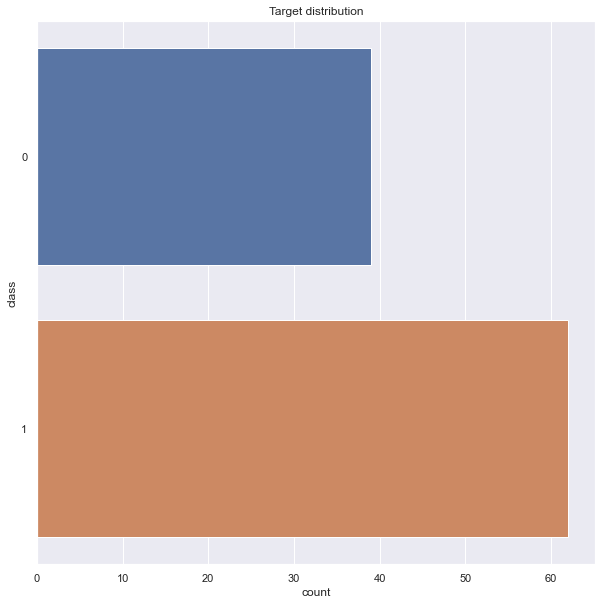

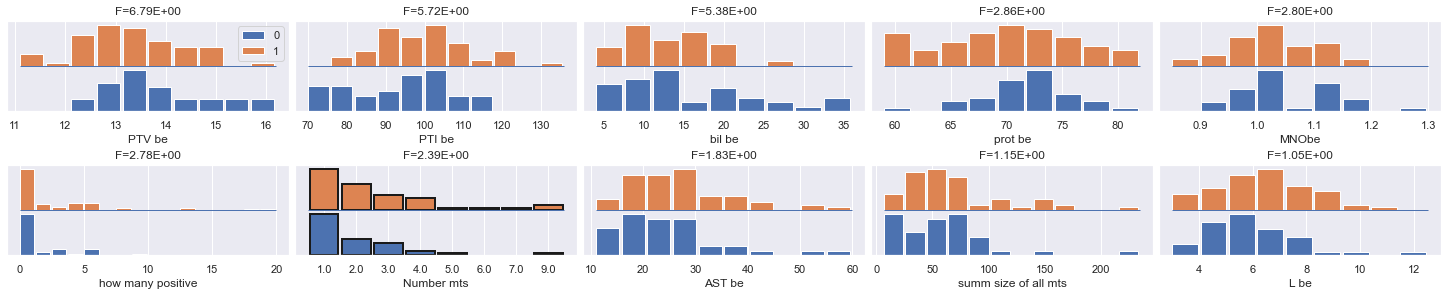

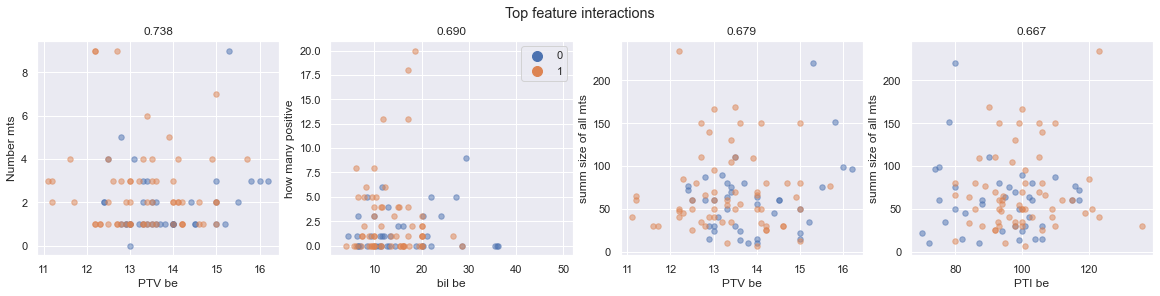

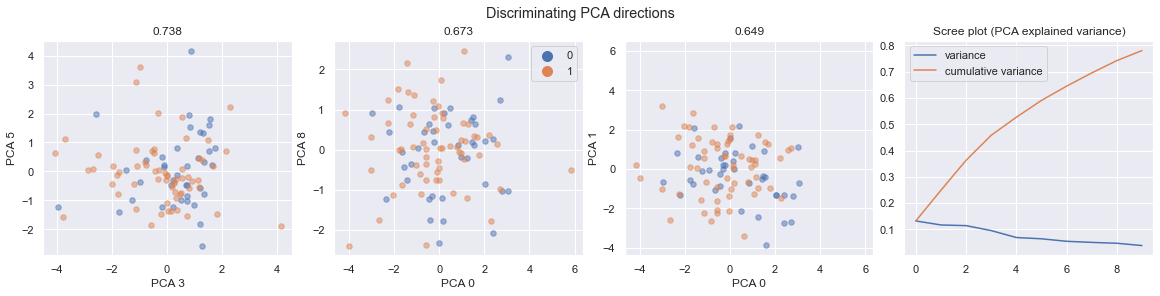

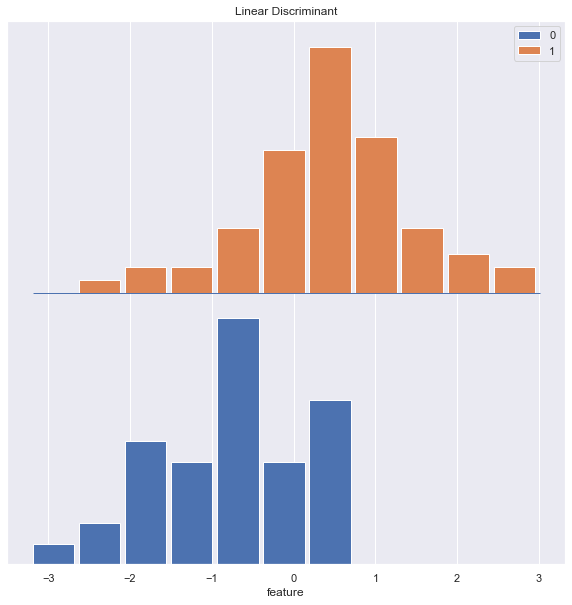

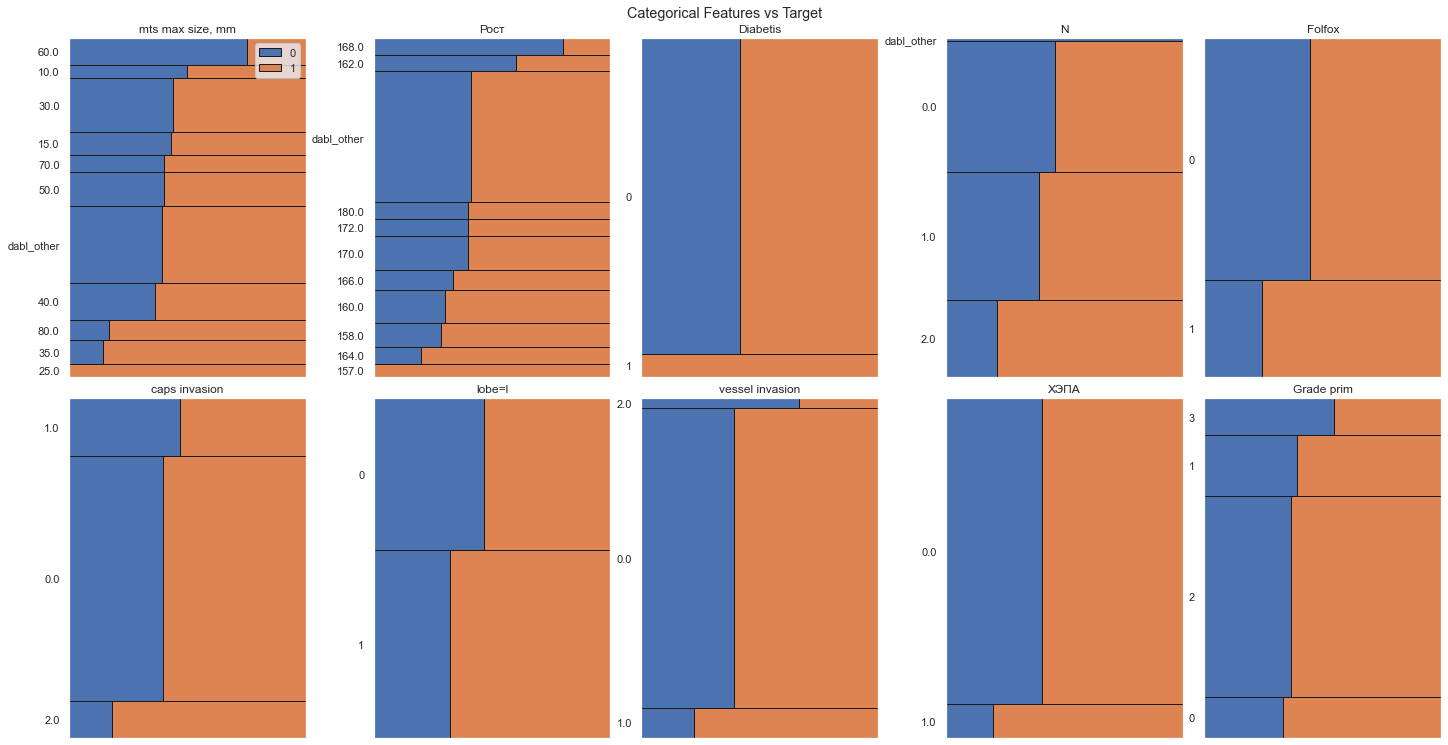

In [93]:
import dabl

dabl.plot(df, target_col='Outcome')

In [95]:
sc = dabl.SimpleClassifier().fit(xtrain_scaled, ytrain)

Running DummyClassifier()
accuracy: 0.614 average_precision: 0.386 roc_auc: 0.500 recall_macro: 0.500 f1_macro: 0.380
=== new best DummyClassifier() (using recall_macro):
accuracy: 0.614 average_precision: 0.386 roc_auc: 0.500 recall_macro: 0.500 f1_macro: 0.380

Running GaussianNB()
accuracy: 0.414 average_precision: 0.467 roc_auc: 0.517 recall_macro: 0.484 f1_macro: 0.389
Running MultinomialNB()
accuracy: 0.543 average_precision: 0.461 roc_auc: 0.532 recall_macro: 0.511 f1_macro: 0.491
=== new best MultinomialNB() (using recall_macro):
accuracy: 0.543 average_precision: 0.461 roc_auc: 0.532 recall_macro: 0.511 f1_macro: 0.491

Running DecisionTreeClassifier(class_weight='balanced', max_depth=1)
accuracy: 0.600 average_precision: 0.452 roc_auc: 0.513 recall_macro: 0.513 f1_macro: 0.473
=== new best DecisionTreeClassifier(class_weight='balanced', max_depth=1) (using recall_macro):
accuracy: 0.600 average_precision: 0.452 roc_auc: 0.513 recall_macro: 0.513 f1_macro: 0.473

Running Decis

In [99]:
print("Accuracy score", sc.score(xtest_scaled, ytest))
print("Accuracy score", sc.score(xtrain_scaled, ytrain))

Accuracy score 0.5806451612903226
Accuracy score 0.8428571428571429


C:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\dabl\plot\utils.py:378: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(


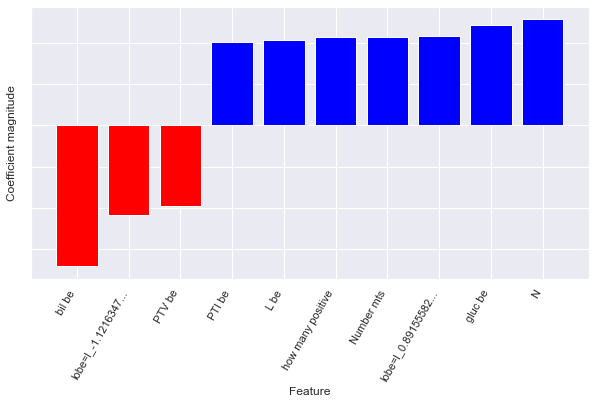

In [211]:
dabl.explain(sc)

Target looks like classification


C:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\dabl\plot\utils.py:632: UserWarning: Dropped 1 outliers in column bil be.
  warn("Dropped {} outliers in column {}.".format(
C:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\dabl\plot\utils.py:632: UserWarning: Dropped 1 outliers in column CEA before.
  warn("Dropped {} outliers in column {}.".format(
C:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\dabl\plot\utils.py:632: UserWarning: Dropped 1 outliers in column AST be.
  warn("Dropped {} outliers in column {}.".format(
C:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\dabl\plot\utils.py:632: UserWarning: Dropped 1 outliers in column gluc be.
  warn("Dropped {} outliers in column {}.".format(
C:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\dabl\plot\utils.py:632: UserWarning: Dropped 1 outliers in column creat be.
  warn("Dropped {} outliers in column {}.".format(


Linear Discriminant Analysis training set score: 0.738
Showing only top 10 of 37 categorical features


C:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\dabl\plot\utils.py:374: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(
C:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\dabl\plot\utils.py:374: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(
C:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\dabl\plot\utils.py:374: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(
C:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\dabl\plot\utils.py:374: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


[[<Figure size 1440x576 with 20 Axes>,
  <Figure size 1152x288 with 4 Axes>,
  <Figure size 1152x288 with 4 Axes>,
  <Figure size 720x720 with 1 Axes>],
 None]

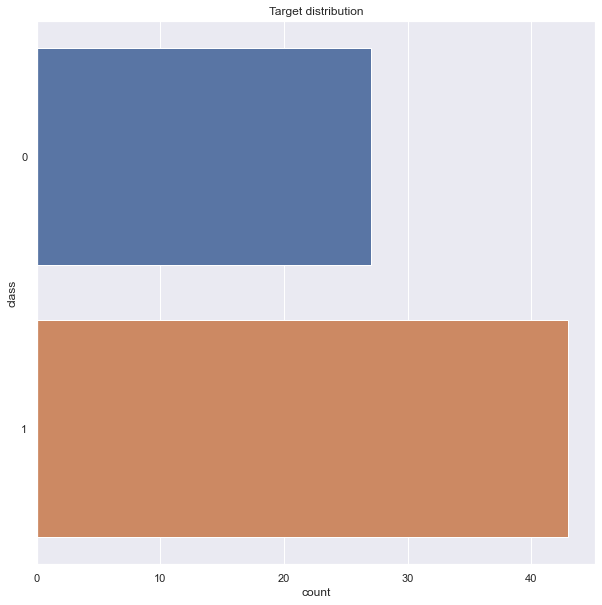

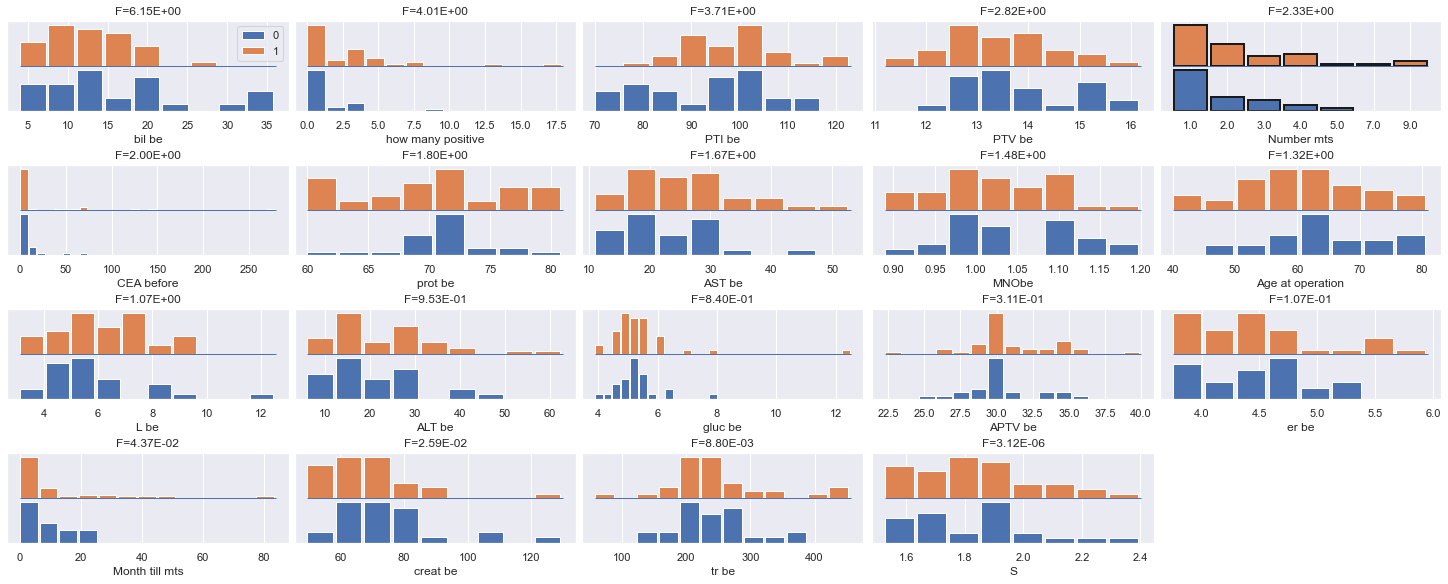

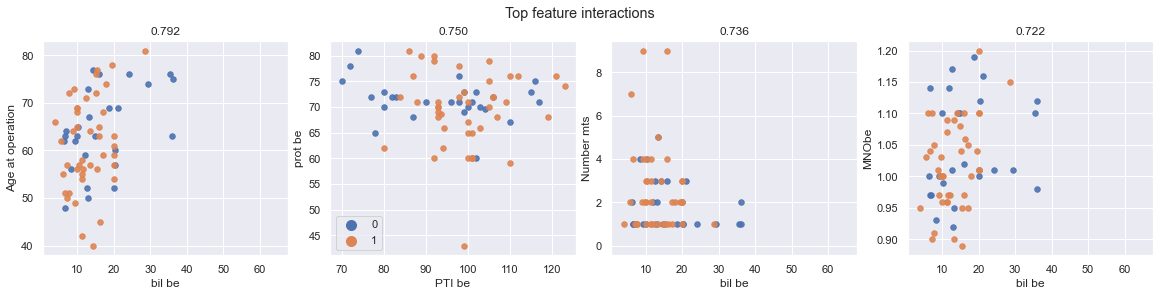

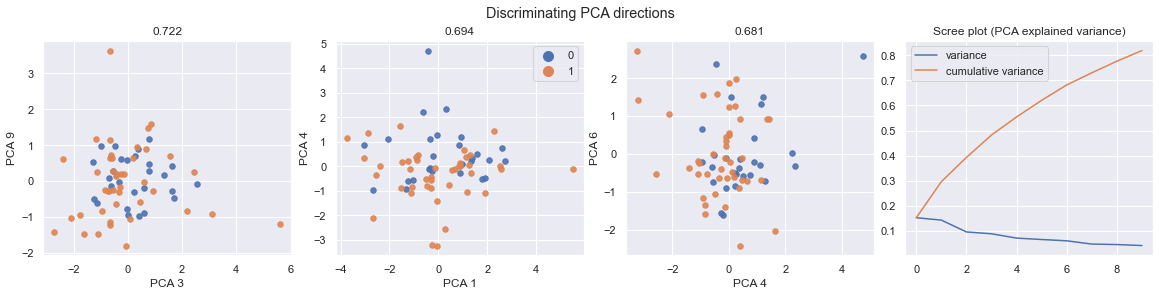

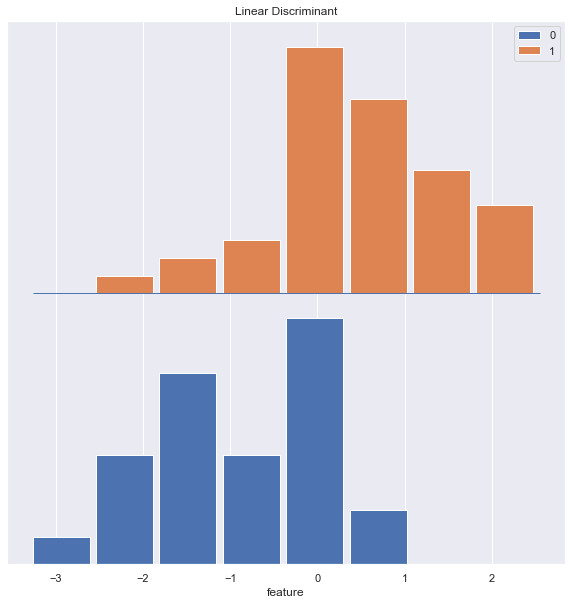

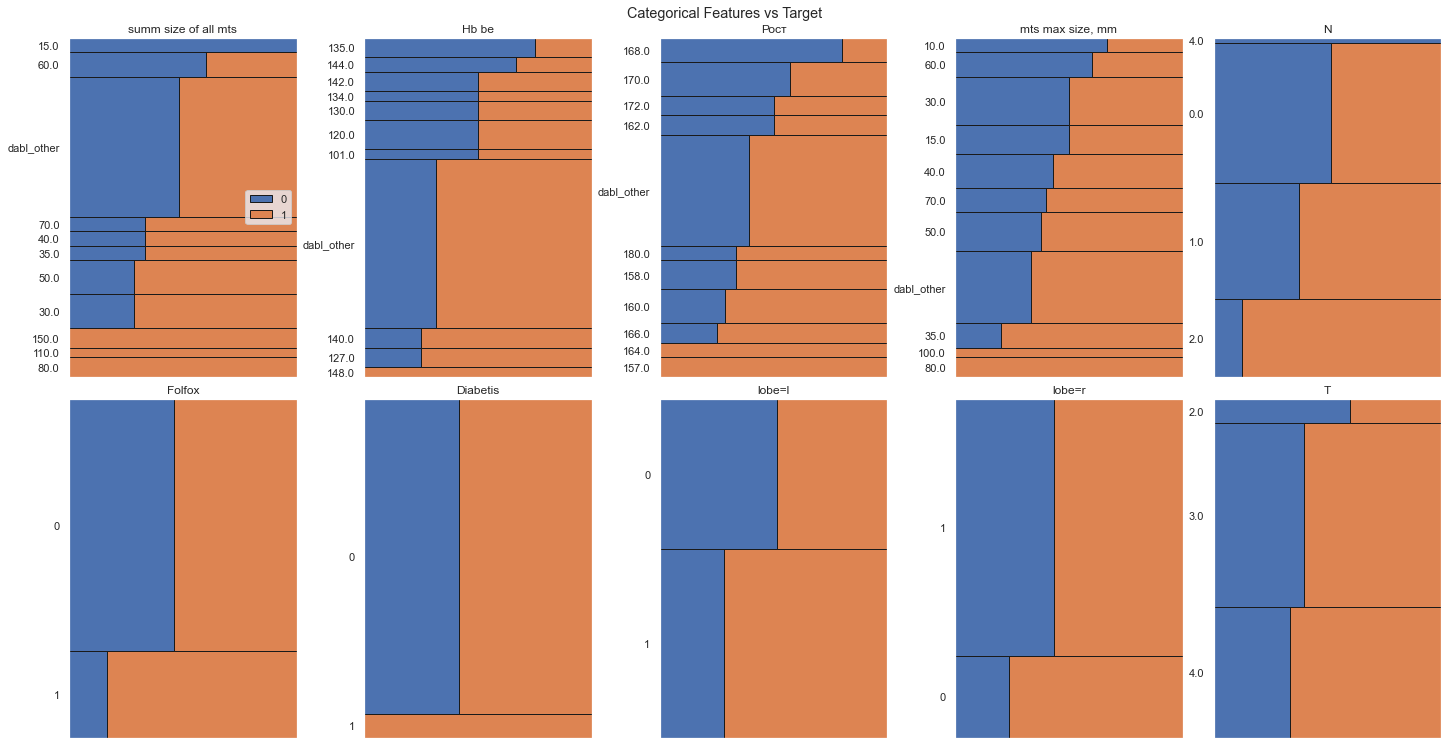

In [104]:
dabl.plot(xtrain, ytrain)

In [219]:
len(quant_feat)

13

In [222]:
ax.ravel()

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:xlabel='Month till mts'>], dtype=object)

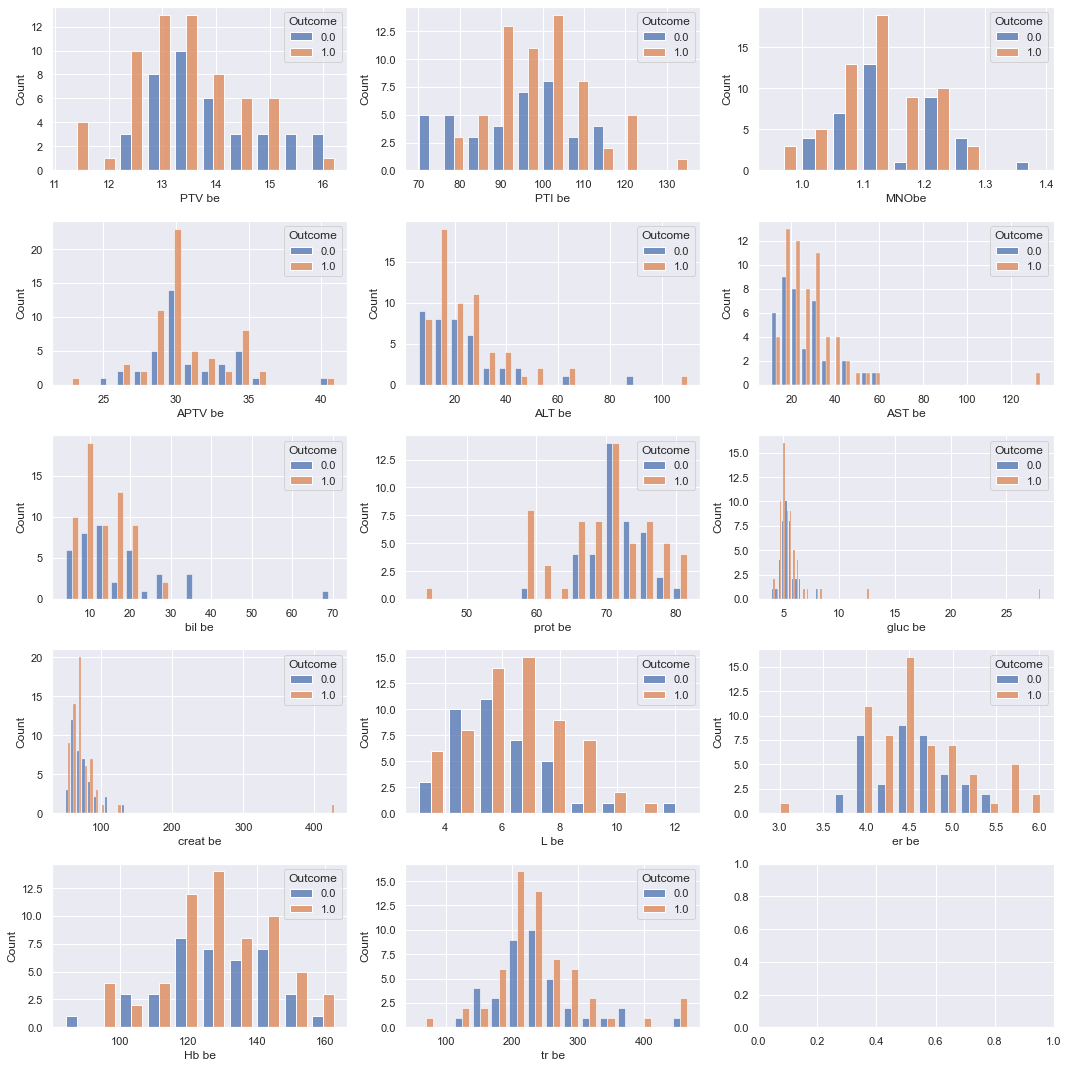

In [228]:
from dabl.plot import class_hists
plt.rcParams["figure.figsize"] = (15, 15)

fig, ax = plt.subplots(5, 3)
ax = ax.ravel()

for i in enumerate(be_features):
    # class_hists(df, i[1], 'Outcome', legend=True, ax=ax[i[0]])
    sns.histplot(data=df, x=i[1], hue='Outcome', multiple="dodge", shrink=.8, legend=True, ax=ax[i[0]])

plt.tight_layout()
plt.show()

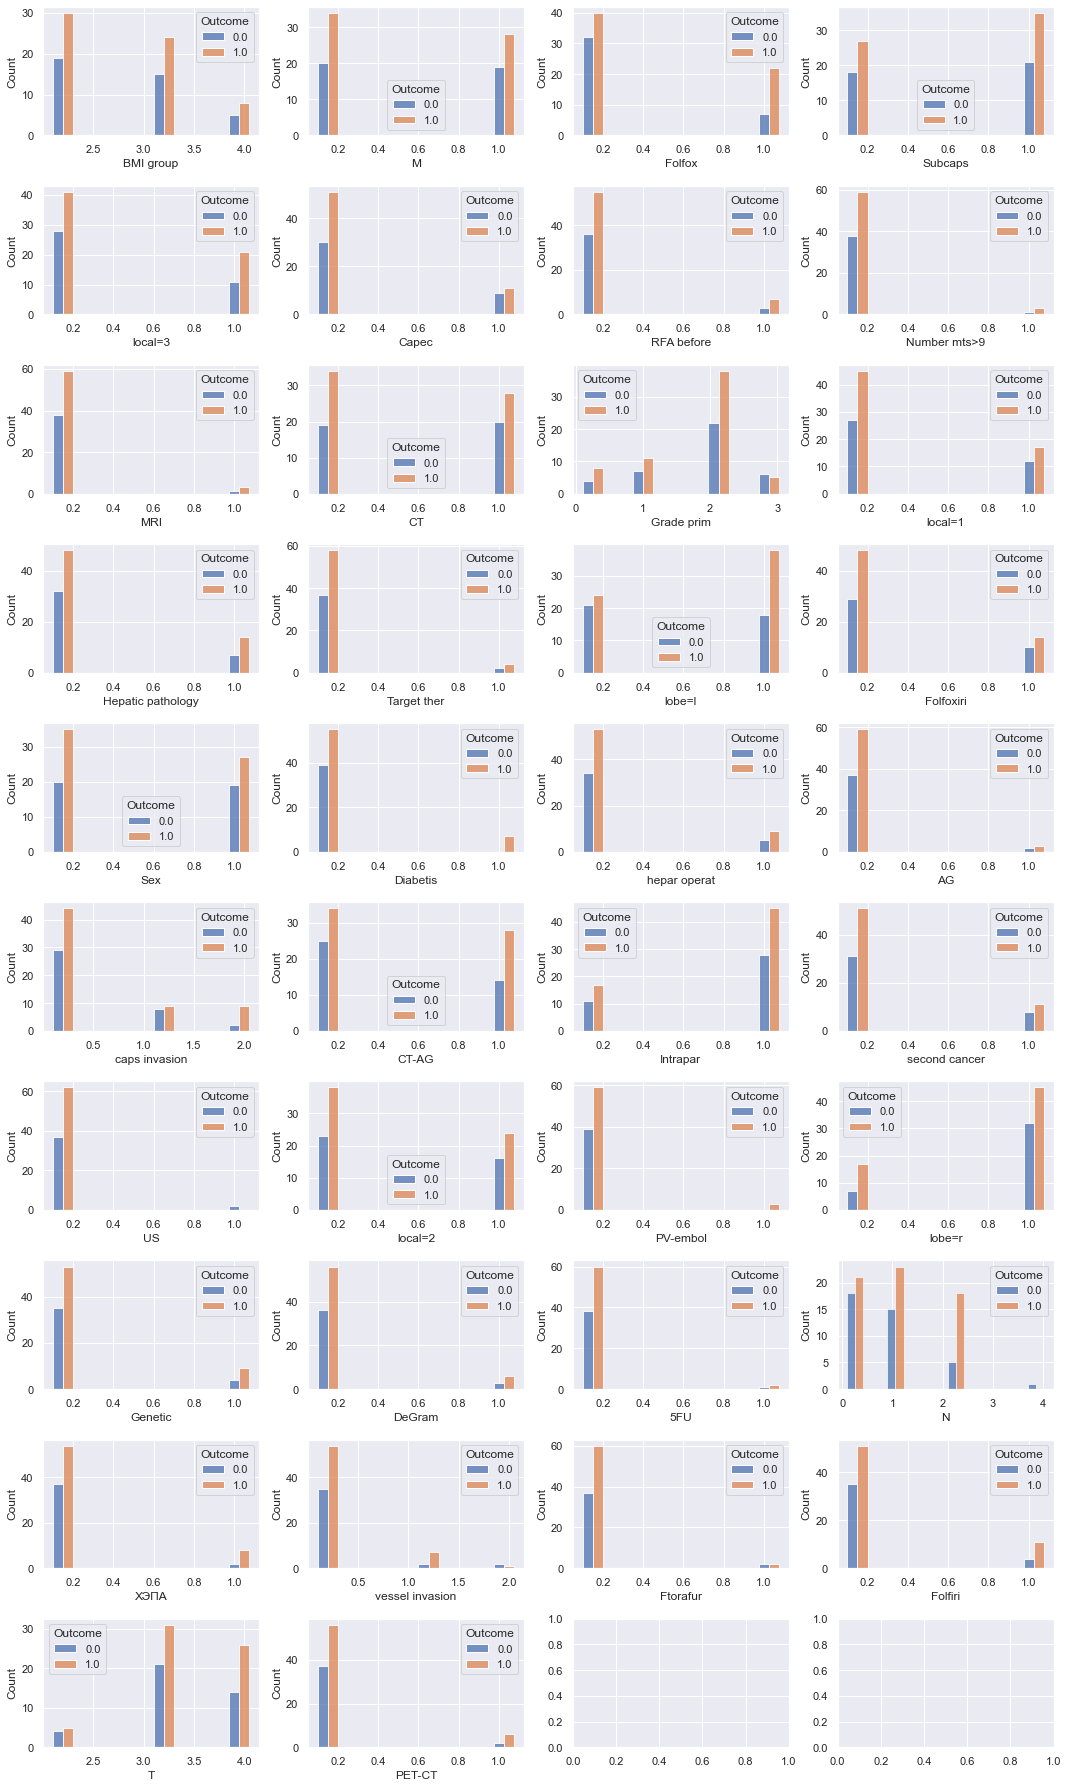

In [39]:
from dabl.plot import class_hists
plt.rcParams["figure.figsize"] = (15, 25)

fig, ax = plt.subplots(10, 4)
ax = ax.ravel()

for i in enumerate(cat_feat):
    # class_hists(df, i[1], 'Outcome', legend=True, ax=ax[i[0]])
    sns.histplot(data=df, x=i[1], hue='Outcome', multiple="dodge", shrink=.8, legend=True, ax=ax[i[0]])

plt.tight_layout()
plt.show()

In [40]:
len(cat_feat)

38

# Шкала Фонга : Fong Clinical Risk Score

In [32]:
factors = [
    'how many positive', # node-positive primary how many positive   hylar L/N
    'Month till mts', # Disease-free interval <12 months
    'Number mts', # >1 hepatic tumor 
    'CEA before', # Preoperative CEA level >200 ng/mL 
    'mts max size, mm' # Size of largest hepatic tumor >5cm
]

count      61.000000
mean       64.070328
std       176.565630
min         0.100000
25%         2.700000
50%         9.300000
75%        44.200000
max      1000.000000
Name: CEA before, dtype: float64


<AxesSubplot:>

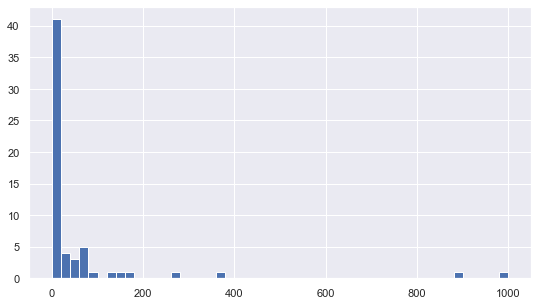

In [33]:
plt.rcParams["figure.figsize"] = (9,5)
print(df['CEA before'].describe())
df['CEA before'].hist(bins=50)

<AxesSubplot:>

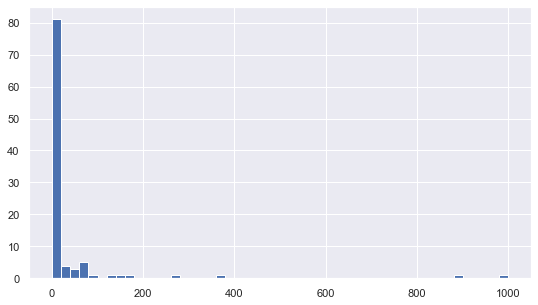

In [34]:
df['CEA before'].fillna(df['CEA before'].median()).hist(bins=50)

In [35]:
df['CEA before'].fillna(df['CEA before'].median(), inplace=True)

### calc_score

In [36]:
def calc_score(x, factors):
    # print(x[factors[0]], int(x[factors[0]]>0))
    # print(x[factors[1]], int(x[factors[1]]<12))
    # print(x[factors[2]], int(x[factors[2]]>1))
    # print(x[factors[3]], int(x[factors[3]]>200))
    # print(x[factors[4]], int(x[factors[4]]>50))

    return 1.0 * (
        int(x[factors[0]]>0) + 
        int(x[factors[1]]<12) + 
        int(x[factors[2]]>=1) + 
        int(x[factors[3]]>200) + 
        int(x[factors[4]]>=50)
    )

# CEA before - куча так-то нулей : 49

scales = pd.concat(
    [df[factors+scale_score],
    df[factors+scale_score].apply(lambda x: calc_score(x, factors), axis=1)],
    axis=1
)
scales.columns = factors+['their']+['mine']
noteq = scales[scales['their']!=scales['mine']]